<a href="https://colab.research.google.com/github/RozaSekouri/Alternative-time-series-project-Roza/blob/main/Copy_of_Final_Project_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install kagglehub
!pip install wordcloud
!pip install nltk
!pip install torch -qq
!pip install pyarrow -qq
!pip install transformers accelerate evaluate datasets -qq
import pandas as pd
import os
import kagglehub
import ast
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import evaluate
from datasets import Dataset
from tqdm.notebook import tqdm
import joblib
from torch.utils.data import DataLoader
import gc
import json

Generate Kaggle API Token:

Go to Kaggle.

Log in to your account.

Click on your profile picture in the top right corner and select "My Account".

Scroll down to the "API" section and click "Create New API Token". This will download a kaggle.json file to your computer.

Upload kaggle.json to Colab:

In your Colab notebook, run the following cell. It will prompt you to upload the kaggle.json file.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rosasekouri","key":"2d483ba861bcdfc13cce09a8f940d305"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

Dataset URL: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe
License(s): CC0-1.0
  0% 0.00/45.1M [00:00<?, ?B/s]
100% 45.1M/45.1M [00:00<00:00, 1.26GB/s]


In [ ]:
!unzip 515k-hotel-reviews-data-in-europe.zip

Archive:  515k-hotel-reviews-data-in-europe.zip
  inflating: Hotel_Reviews.csv       


In [ ]:
# Define the path to unzipped CSV file
file_path = 'Hotel_Reviews.csv'

# Load the CSV into a Pandas DataFrame
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("DataFrame loaded successfully!")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataFrame Info (columns, non-null counts, dtypes):")
    df.info()

    print(f"\nTotal rows in DataFrame: {df.shape[0]}")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure you unzipped the file correctly and it's in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")

DataFrame loaded successfully!

First 5 rows:
                                       Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1           

In [ ]:
# Show the number of rows and columns (DataFrame shape)
print("DataFrame Shape (Rows, Columns):")
print(df.shape)

# Show the names of all columns
print("\nDataFrame Column Names:")
print(df.columns.tolist()) # .tolist() makes it print as a neat list

DataFrame Shape (Rows, Columns):
(515738, 17)

DataFrame Column Names:
['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', 'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags', 'days_since_review', 'lat', 'lng']


In [ ]:
print("\nDetailed Missing Values Count:")
print(df.isnull().sum())


Detailed Missing Values Count:
Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64


In [ ]:
print("\nNumber of Duplicate Rows:")
num_duplicates = df.duplicated().sum()
print(f"Found {num_duplicates} duplicate rows.")

if num_duplicates > 0:
    print("Removing duplicate rows...")
    df.drop_duplicates(inplace=True)
    print(f"Duplicates removed. New DataFrame shape: {df.shape}")
else:
    print("No duplicate rows found.")


Number of Duplicate Rows:
Found 526 duplicate rows.
Removing duplicate rows...
Duplicates removed. New DataFrame shape: (515212, 17)


In [ ]:
df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')

# Concatenate positive and negative reviews to form a single 'Review_Text' column.
# Add a space in between if both are present.
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']

# Remove leading/trailing spaces and handle multiple spaces
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Drop the temporary clean columns if no longer needed
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)

In [ ]:
print(df.shape)

(515212, 18)


In [ ]:
df.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng                                        Review_Text  
0  52.360576  4.915968  Only the park outside of the hotel was beautif...  
1  52.360576  4.915968  No real complaints the hotel was great great l...  
2  52.360576  4.915968  Location was good and staff were ok It is cute...  
3  52.360576  4.915968  Great location in nice surroundings the bar an...  
4  52.360576  4.915968  Amazing location and building Romantic setting...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515212 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515212 non-null  object 
 1   Additional_Number_of_Scoring                515212 non-null  int64  
 2   Review_Date                                 515212 non-null  object 
 3   Average_Score                               515212 non-null  float64
 4   Hotel_Name                                  515212 non-null  object 
 5   Reviewer_Nationality                        515212 non-null  object 
 6   Negative_Review                             515212 non-null  object 
 7   Review_Total_Negative_Word_Counts           515212 non-null  int64  
 8   Total_Number_of_Reviews                     515212 non-null  int64  
 9   Positive_Review                             515212 non-null  object 
 10  R

In [ ]:
df.describe()

Additional_Number_of_Scoring  Average_Score  \
count                 515212.000000  515212.000000   
mean                     498.416021       8.397767   
std                      500.668595       0.547952   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      342.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515212.000000            515212.000000   
mean                           18.540822              2744.698889   
std                            29.693991              2318.090821   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3633.000000   
max                           408.000000             16670.000000   

       Review_Total_Positive_Word_Counts  \
count                      515212.000000   
mean                           17.778256   
std                            21.804541   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
count                               515212.000000   515212.000000   
mean                                     7.164895        8.395532   
std                                     11.039354        1.637467   
min                                      1.000000        2.500000   
25%                                      1.000000        7.500000   
50%                                      3.000000        8.800000   
75%                                      8.000000        9.600000   
max                                    355.000000       10.000000   

                 lat            lng  
count  511944.000000  511944.000000  
mean       49.443040       2.824222  
std         3.468029       4.581637  
min        41.328376      -0.369758  
25%        48.214277      -0.143649  
50%        51.499981      -0.000250  
75%        51.516288       4.834443  
max        52.400181      16.429233

In [ ]:
# Displaying top 20 unique hotel names, as there will be many
print(df['Hotel_Name'].value_counts().head(20))
print(f"\nTotal unique hotels: {df['Hotel_Name'].nunique()}")

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3577
DoubleTree by Hilton Hotel London Tower of London    3212
Grand Royale London Hyde Park                        2958
Holiday Inn London Kensington                        2768
Hilton London Metropole                              2628
Millennium Gloucester Hotel London                   2565
Intercontinental London The O2                       2551
Park Grand Paddington Court                          2288
Hilton London Wembley                                2227
Park Plaza County Hall London                        2223
Blakemore Hyde Park                                  2178
Park Plaza London Riverbank                          2167
M by Montcalm Shoreditch London Tech City            2155
DoubleTree by Hilton London Docklands Riverside      2147
St 

In [ ]:
# Displaying top 20 unique nationalities for brevity, as there might be many
print(df['Reviewer_Nationality'].value_counts().head(20))
print(f"\nTotal unique nationalities: {df['Reviewer_Nationality'].nunique()}")

Reviewer_Nationality
United Kingdom               245110
United States of America      35349
Australia                     21648
Ireland                       14814
United Arab Emirates          10229
Saudi Arabia                   8940
Netherlands                    8757
Switzerland                    8669
Germany                        7929
Canada                         7883
France                         7265
Israel                         6601
Italy                          6113
Belgium                        6024
Turkey                         5440
Kuwait                         4915
Spain                          4735
Romania                        4548
Russia                         3898
South Africa                   3816
Name: count, dtype: int64

Total unique nationalities: 227


In [ ]:
# The 'Tags' column is a string containing multiple tags separated by commas.
# To get truly unique individual tags, we need to process this column.
# Let's show a few raw examples first.
print("\nExample raw 'Tags' entries:")
print(df['Tags'].head().tolist())


Example raw 'Tags' entries:
["[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 6 nights ']", "[' Leisure trip ', ' Couple ', ' Duplex Double Room ', ' Stayed 4 nights ']", "[' Leisure trip ', ' Family with young children ', ' Duplex Double Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']", "[' Leisure trip ', ' Solo traveler ', ' Duplex Double Room ', ' Stayed 3 nights ']", "[' Leisure trip ', ' Couple ', ' Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']"]


In [ ]:
# To get actual individual unique tags, we need to split and explode the strings
# This process might be computationally intensive for very large datasets if not optimized.
# Let's get a sample of common tags first
# This is a good step for later preprocessing, just showing a few unique combinations for now.
print(f"\nTotal unique combinations of tags: {df['Tags'].nunique()}")
print("Top 100 most frequent tag combinations:")
df['Tags'].value_counts().head(100)


Total unique combinations of tags: 55242
Top 100 most frequent tag combinations:


Tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                     5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']            4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']            4362
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              3986
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                    3291
                                                                                                                            ... 
[' Leisure trip ', ' Couple ', ' Standard Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']               576
[' Leisure trip ', ' Couple ', ' Deluxe Double ', ' Stayed 1 night ', ' Submitted from a mobile device ']                    575
[' Leisure trip ', ' Family with young children ', ' 2 rooms ', ' Stayed 3 nights ', ' Submitted from a mobile device ']     570
[' Leisure trip ', ' Solo traveler ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']      570
[' Leisure trip ', ' Couple ', ' King Guest Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                  568
Name: count, Length: 100, dtype: int64

In [ ]:
# --- Analyze the Reviewer_Score distribution ---
print("\n--- Distribution of 'Reviewer_Score' ---")
print(df['Reviewer_Score'].value_counts().sort_index())
print(f"\nMean Reviewer Score: {df['Reviewer_Score'].mean():.2f}")
print(f"Median Reviewer Score: {df['Reviewer_Score'].median():.2f}")
print(f"Min Reviewer Score: {df['Reviewer_Score'].min():.2f}")
print(f"Max Reviewer Score: {df['Reviewer_Score'].max():.2f}")


--- Distribution of 'Reviewer_Score' ---
Reviewer_Score
2.5       2192
2.9       1583
3.0         37
3.1          8
3.3       2765
3.5         79
3.8       4035
4.0         84
4.2       5089
4.4         12
4.5        122
4.6       6226
5.0       8408
5.4       9518
5.5        227
5.6         17
5.8      12014
6.0        253
6.3      14909
6.5        345
6.7      18765
6.9         29
7.0        410
7.1      24837
7.5      34831
7.9      33062
8.0        505
8.1         39
8.3      41090
8.5        508
8.8      46386
9.0        646
9.2      58526
9.4         63
9.5        724
9.6      71110
10.0    115758
Name: count, dtype: int64

Mean Reviewer Score: 8.40
Median Reviewer Score: 8.80
Min Reviewer Score: 2.50
Max Reviewer Score: 10.00


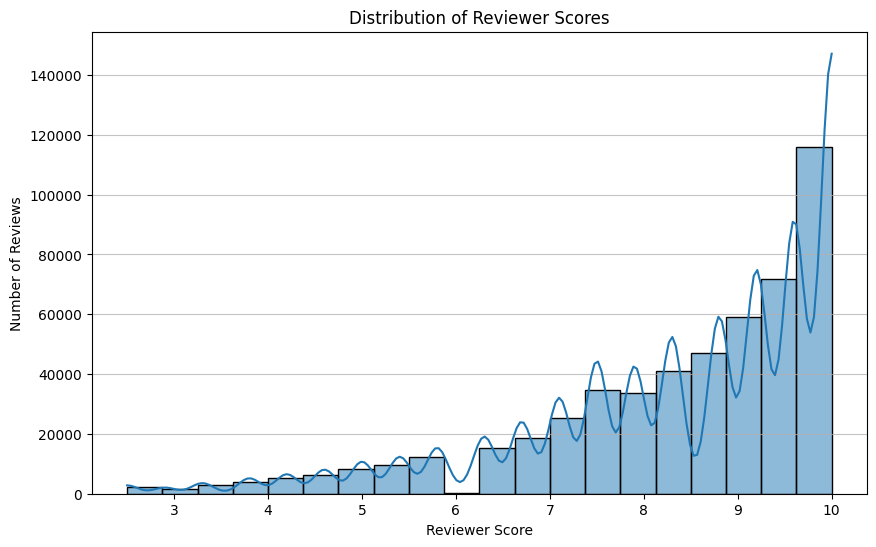

In [ ]:
# We can also visualize this distribution with a histogram
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['Reviewer_Score'], bins=20, kde=True)
plt.title('Distribution of Reviewer Scores')
plt.xlabel('Reviewer Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

# --- Step 1: Convert 'Tags' string to an actual list of strings ---

In [ ]:
# Use ast.literal_eval to safely parse the string representation of a list
def parse_tags_string(tags_str):
    try:
        # Evaluate the string as a Python literal (list in this case)
        # Then strip whitespace from each tag
        return [tag.strip() for tag in ast.literal_eval(tags_str)]
    except (ValueError, SyntaxError):
        return [] # Return empty list if parsing fails for any reason

df['Tags_List'] = df['Tags'].apply(parse_tags_string)

print("\n--- Example of 'Tags_List' after parsing ---")
print(df[['Tags', 'Tags_List']].head())


--- Example of 'Tags_List' after parsing ---
                                                Tags  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...   
2  [' Leisure trip ', ' Family with young childre...   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...   

                                           Tags_List  
0  [Leisure trip, Couple, Duplex Double Room, Sta...  
1  [Leisure trip, Couple, Duplex Double Room, Sta...  
2  [Leisure trip, Family with young children, Dup...  
3  [Leisure trip, Solo traveler, Duplex Double Ro...  
4  [Leisure trip, Couple, Suite, Stayed 2 nights,...  


# --- Step 2: Define functions to extract specific information ---


In [ ]:
def extract_group_size(tags_list):
    group_size_keywords = {
        'Couple': 'Couple',
        'Solo traveler': 'Solo',
        'Family with young children': 'Family',
        'Family with older children': 'Family',
        'Group': 'Group',
        'Friends': 'Friends',
        'Business traveler': 'Business'
    }
    for tag in tags_list:
        for keyword, category in group_size_keywords.items():
            if keyword in tag:
                return category
    return 'Unknown Group' # Default if no match is found

def extract_room_type(tags_list):
    # Prioritize more specific room types first
    room_type_keywords = [
        'Duplex Double Room', 'Family Room', 'King Room', 'Queen Room',
        'Superior Double Room', 'Deluxe Double Room', 'Standard Double Room',
        'Twin Room', 'Double Room', 'Single Room', 'Triple Room', 'Quadruple Room',
        'Suite', 'Apartment', 'Studio', 'Executive Room', 'Club Room',
        'Standard Room', 'Superior Room', 'Deluxe Room', 'Classic Room'
    ]
    for tag in tags_list:
        for keyword in room_type_keywords:
            if keyword in tag:
                return keyword.replace(' Room', '').strip() # Clean up ' Room' for consistency
    return 'Unknown Room Type' # Default if no match

def extract_length_of_stay(tags_list):
    for tag in tags_list:
        match = re.search(r'Stayed (\d+) night(?:s)?', tag)
        if match:
            return int(match.group(1))
    return None # Return None if length of stay isn't found

def extract_trip_type(tags_list):
    trip_type_keywords = {
        'Leisure trip': 'Leisure',
        'Business trip': 'Business'
    }
    for tag in tags_list:
        for keyword, category in trip_type_keywords.items():
            if keyword in tag:
                return category
    return 'Unknown Trip Type'

def extract_submission_device(tags_list):
    for tag in tags_list:
        if 'Submitted from a mobile device' in tag:
            return 'Mobile'
        elif 'Submitted from a desktop device' in tag: # Assuming this tag might exist, though less common
            return 'Desktop'
    return 'Unknown Device'

# --- Step 3: Apply the extraction functions to create new columns ---

In [ ]:
df['group_size'] = df['Tags_List'].apply(extract_group_size)
df['room_type'] = df['Tags_List'].apply(extract_room_type)
df['length_of_stay'] = df['Tags_List'].apply(extract_length_of_stay)
df['trip_type'] = df['Tags_List'].apply(extract_trip_type)
df['submission_device'] = df['Tags_List'].apply(extract_submission_device)


print("\n--- DataFrame with new extracted columns (head) ---")
print(df[['Tags', 'group_size', 'room_type', 'length_of_stay', 'trip_type', 'submission_device']].head())

print("\n--- Value Counts for New Columns ---")
print("\nGroup Size Distribution:")
print(df['group_size'].value_counts())

print("\nRoom Type Distribution (Top 20):")
print(df['room_type'].value_counts().head(20))

print("\nLength of Stay Distribution (Top 10):")
print(df['length_of_stay'].value_counts().head(10))

print("\nTrip Type Distribution:")
print(df['trip_type'].value_counts())

print("\nSubmission Device Distribution:")
print(df['submission_device'].value_counts())

print("\nDataFrame Info after adding new columns:")
df.info()


--- DataFrame with new extracted columns (head) ---
                                                Tags group_size  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...     Couple   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...     Couple   
2  [' Leisure trip ', ' Family with young childre...     Family   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...       Solo   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...     Couple   

       room_type  length_of_stay trip_type submission_device  
0  Duplex Double             6.0   Leisure    Unknown Device  
1  Duplex Double             4.0   Leisure    Unknown Device  
2  Duplex Double             3.0   Leisure            Mobile  
3  Duplex Double             3.0   Leisure    Unknown Device  
4          Suite             2.0   Leisure            Mobile  

--- Value Counts for New Columns ---

Group Size Distribution:
group_size
Couple           252005
Solo             108431
Family            87295
Group             6


--- Histograms for Numerical Features ---


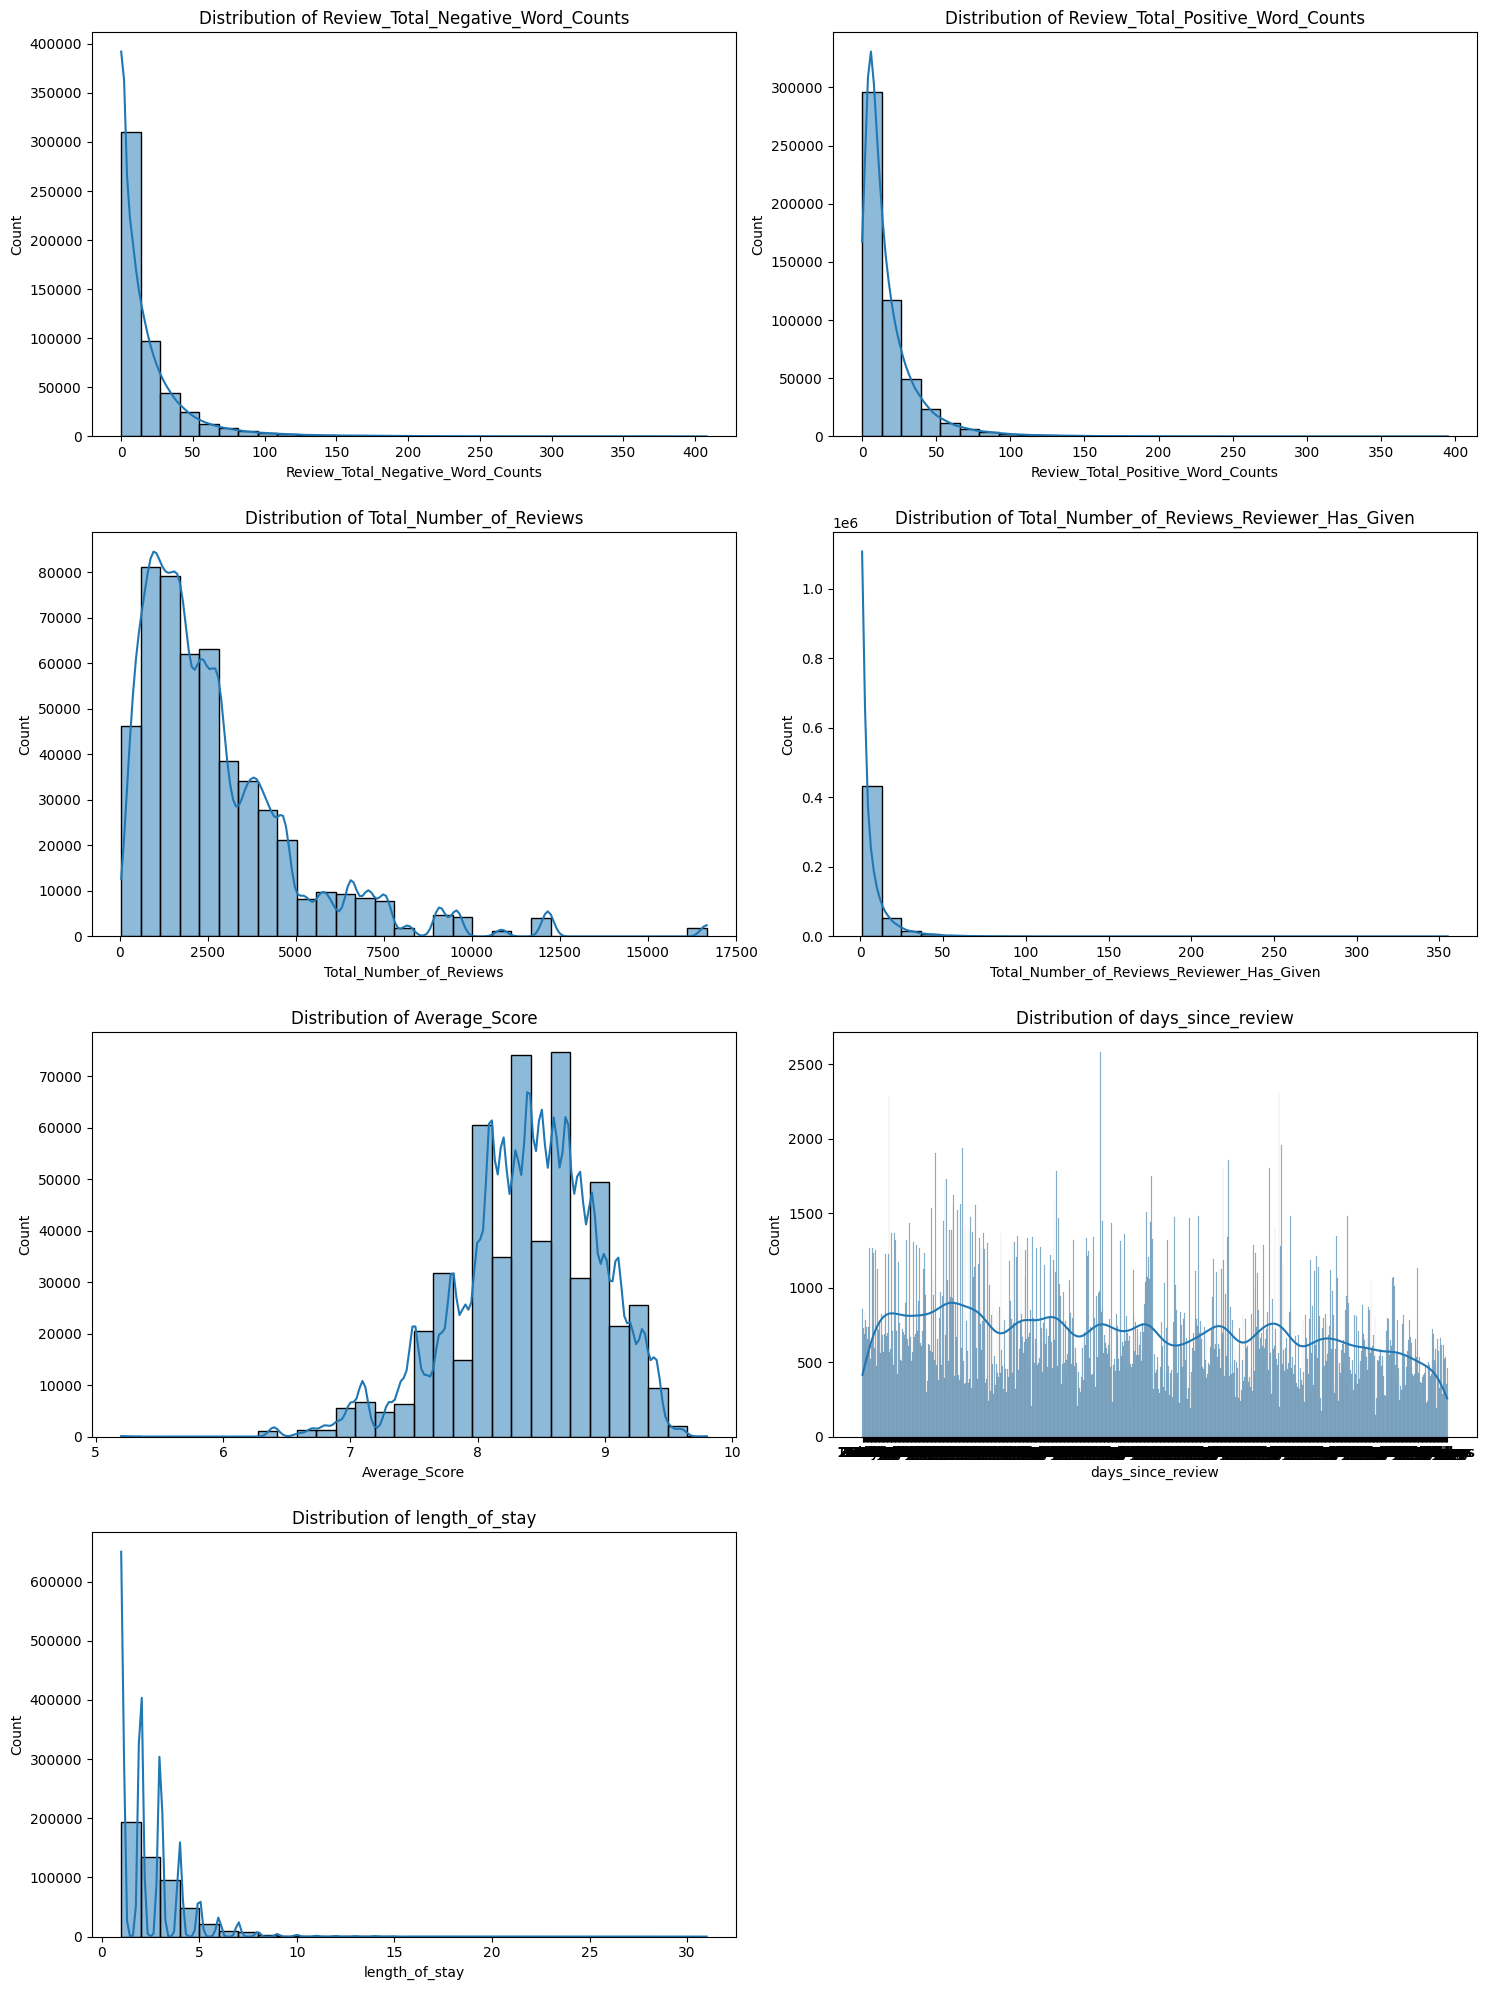


--- Bar Plots for Extracted Categorical Features ---


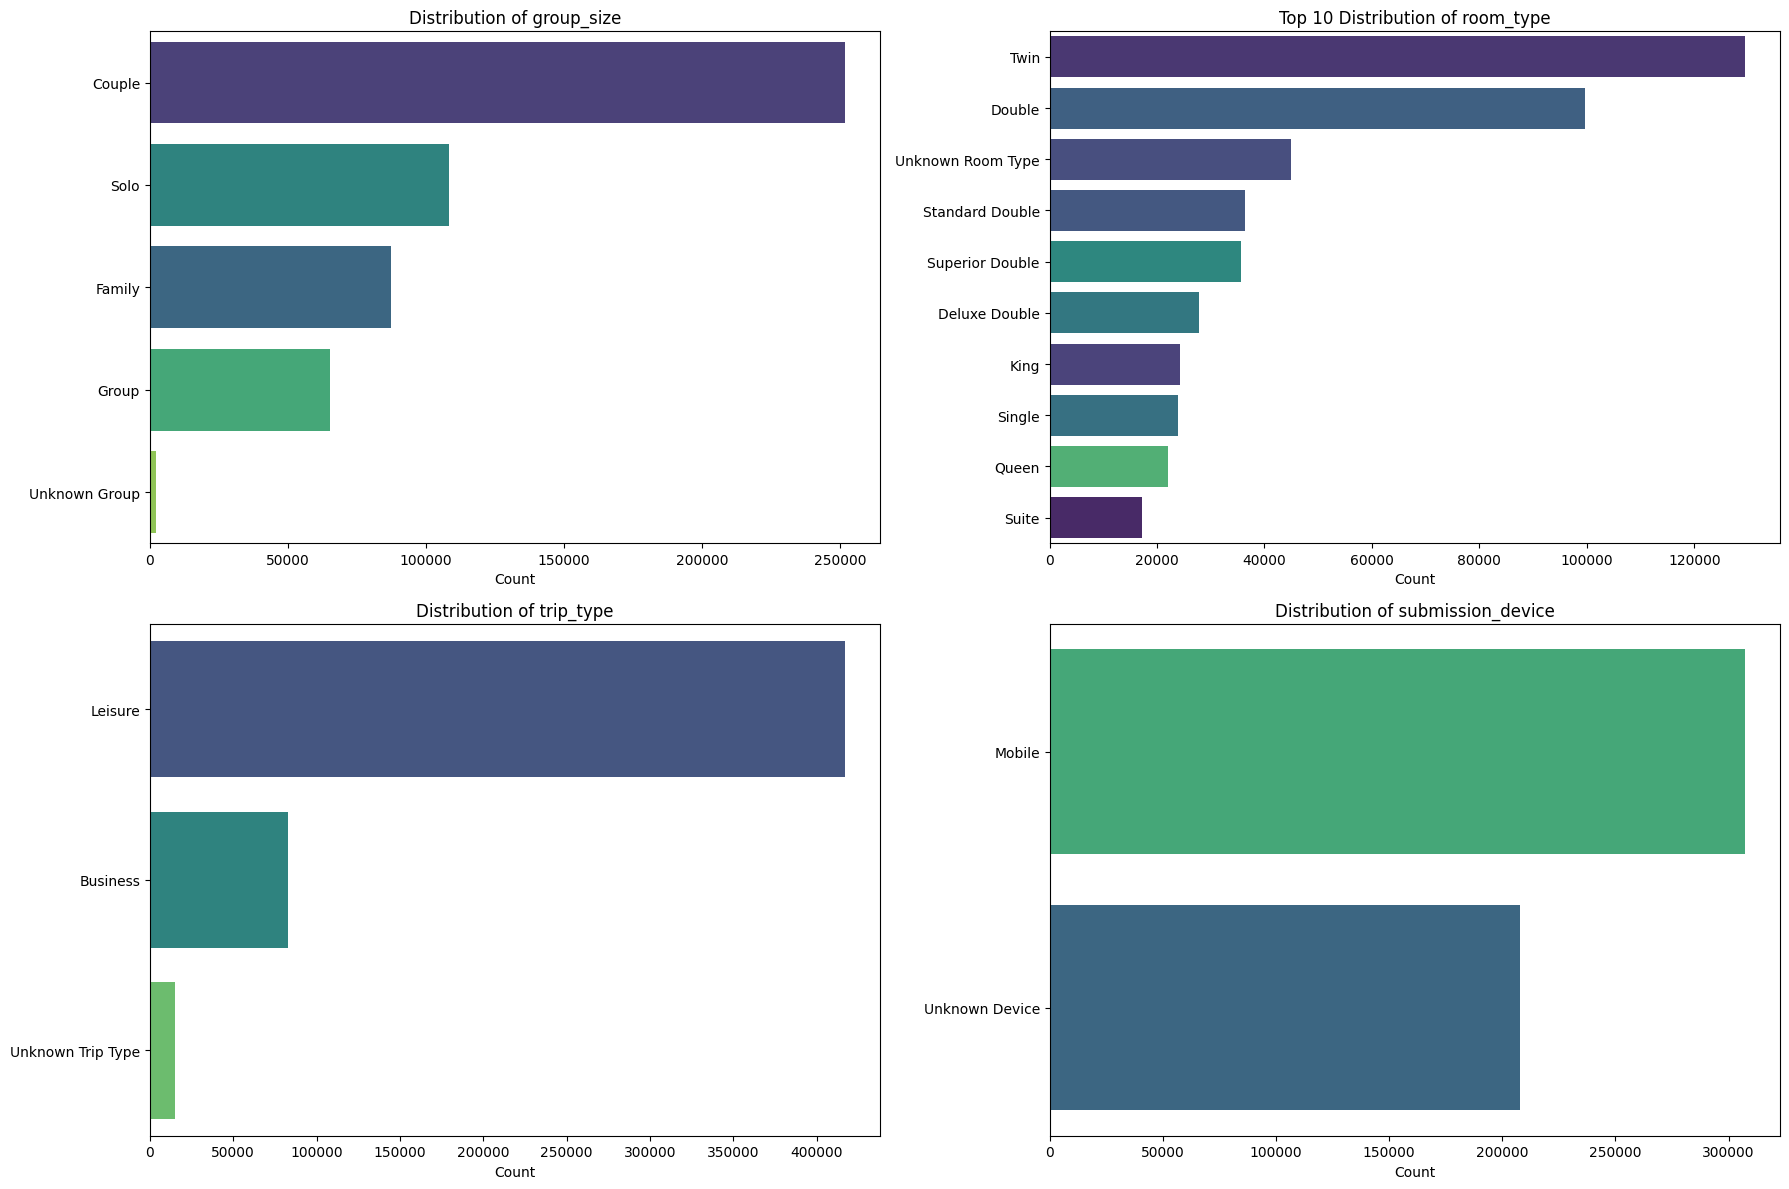


--- Top Reviewer Nationalities ---


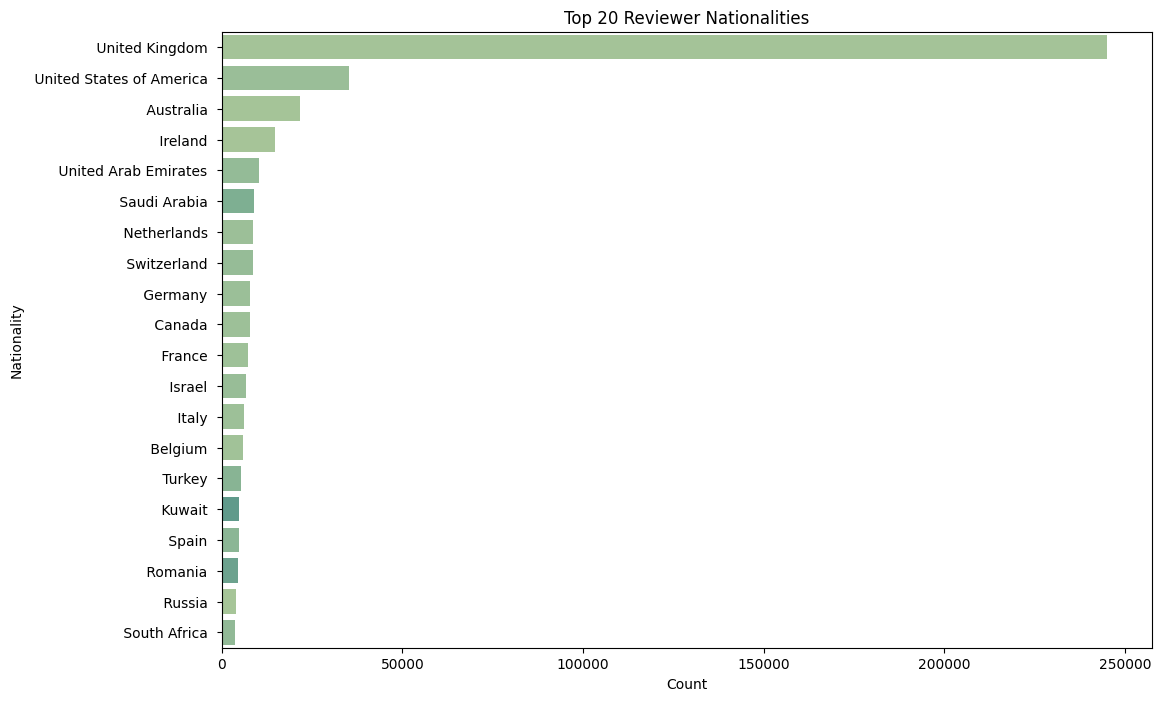

In [ ]:
# --- Numerical Features Histograms ---
numerical_cols = [
    'Review_Total_Negative_Word_Counts',
    'Review_Total_Positive_Word_Counts',
    'Total_Number_of_Reviews',
    'Total_Number_of_Reviews_Reviewer_Has_Given',
    'Average_Score',
    'days_since_review',
    'length_of_stay'
]

print("\n--- Histograms for Numerical Features ---")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten() # Flatten for easy iteration

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# --- Categorical Features Bar Plots ---
categorical_to_plot = [
    'group_size', 'room_type', 'trip_type', 'submission_device'
]

print("\n--- Bar Plots for Extracted Categorical Features ---")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_to_plot):
    # For room_type, take top N to avoid clutter
    if col == 'room_type':
        sns.countplot(y=df[col], order=df[col].value_counts().index[:10], ax=axes[i], palette='viridis', hue=df[col], legend=False)
        axes[i].set_title(f'Top 10 Distribution of {col}')
    else:
        sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette='viridis', hue=df[col], legend=False)
        axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n--- Top Reviewer Nationalities ---")
plt.figure(figsize=(12, 8))
sns.countplot(y='Reviewer_Nationality', data=df, order=df['Reviewer_Nationality'].value_counts().head(20).index, palette='crest', hue='Reviewer_Nationality', legend=False)
plt.title('Top 20 Reviewer Nationalities')
plt.xlabel('Count')
plt.ylabel('Nationality')
plt.show()


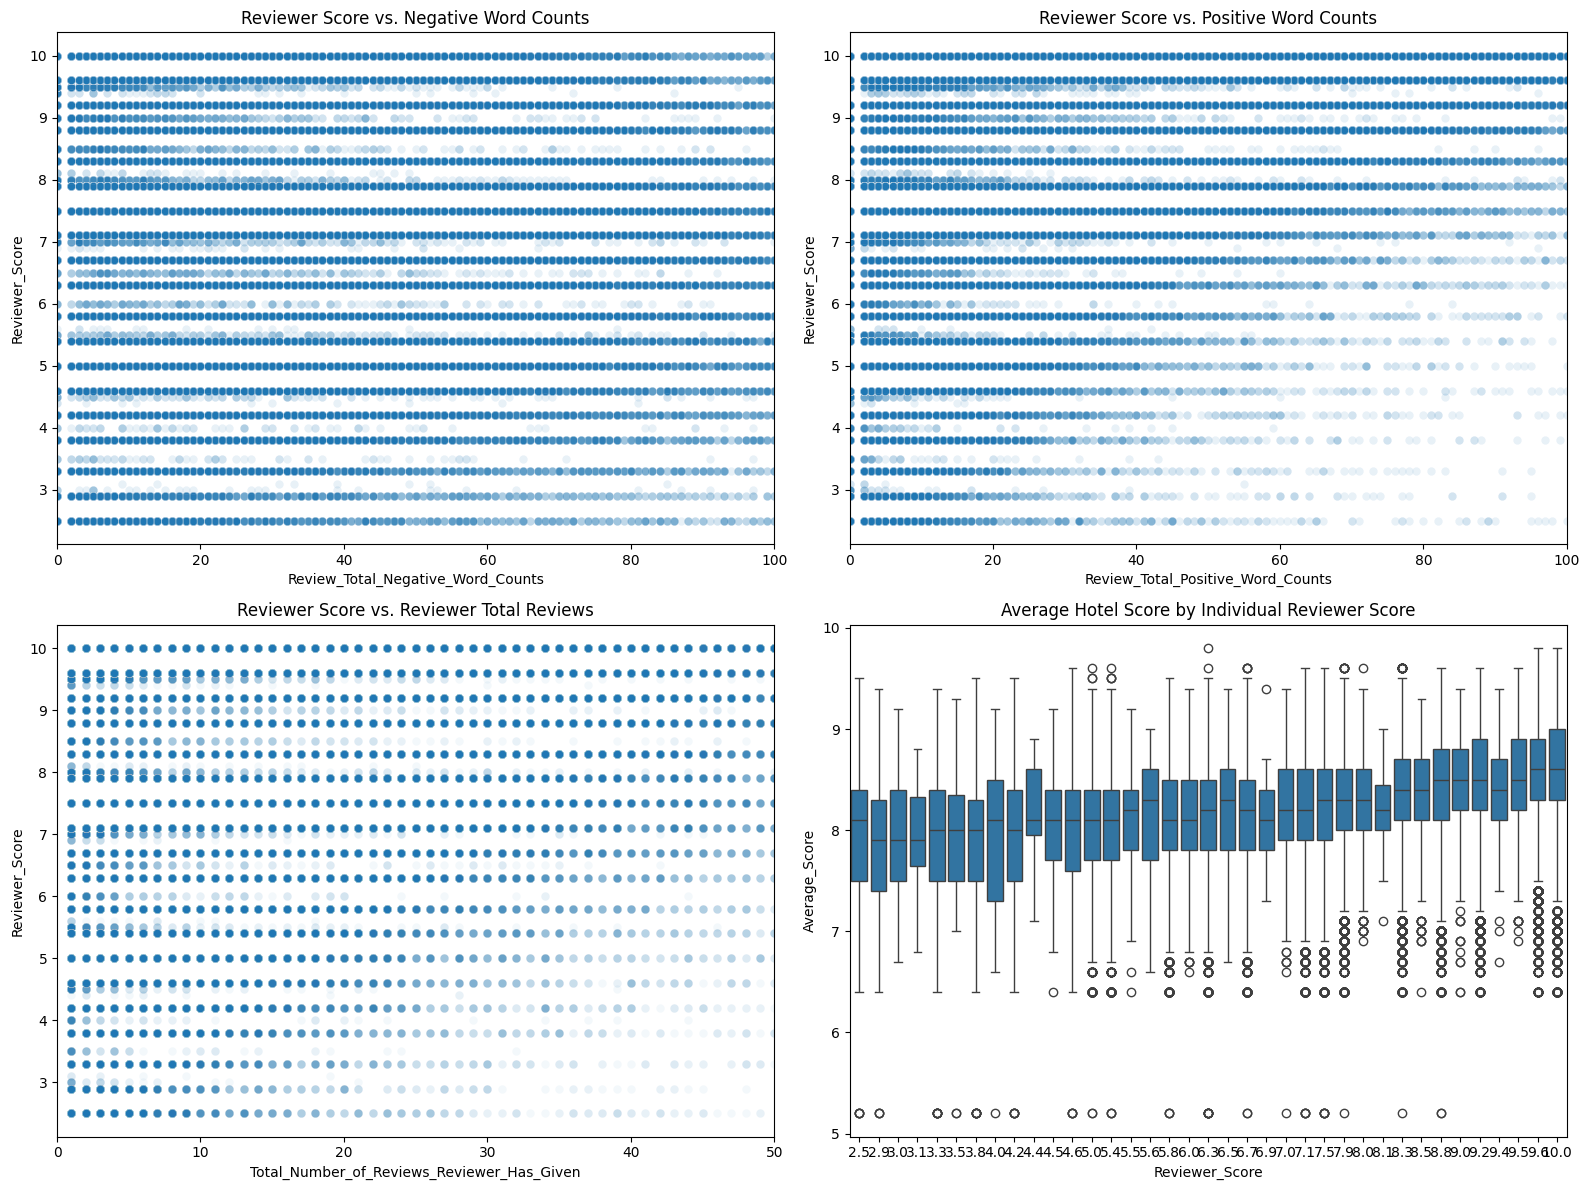

In [ ]:
# Scatter plots for continuous variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

sns.scatterplot(x='Review_Total_Negative_Word_Counts', y='Reviewer_Score', data=df, ax=axes[0], alpha=0.1)
axes[0].set_title('Reviewer Score vs. Negative Word Counts')
axes[0].set_xlim(0, 100)

sns.scatterplot(x='Review_Total_Positive_Word_Counts', y='Reviewer_Score', data=df, ax=axes[1], alpha=0.1)
axes[1].set_title('Reviewer Score vs. Positive Word Counts')
axes[1].set_xlim(0, 100)

sns.scatterplot(x='Total_Number_of_Reviews_Reviewer_Has_Given', y='Reviewer_Score', data=df, ax=axes[2], alpha=0.05)
axes[2].set_title('Reviewer Score vs. Reviewer Total Reviews')
axes[2].set_xlim(0, 50)

sns.boxplot(x='Reviewer_Score', y='Average_Score', data=df, ax=axes[3]) # Box plot, as Average_Score is hotel-level
axes[3].set_title('Average Hotel Score by Individual Reviewer Score')


plt.tight_layout()
plt.show()


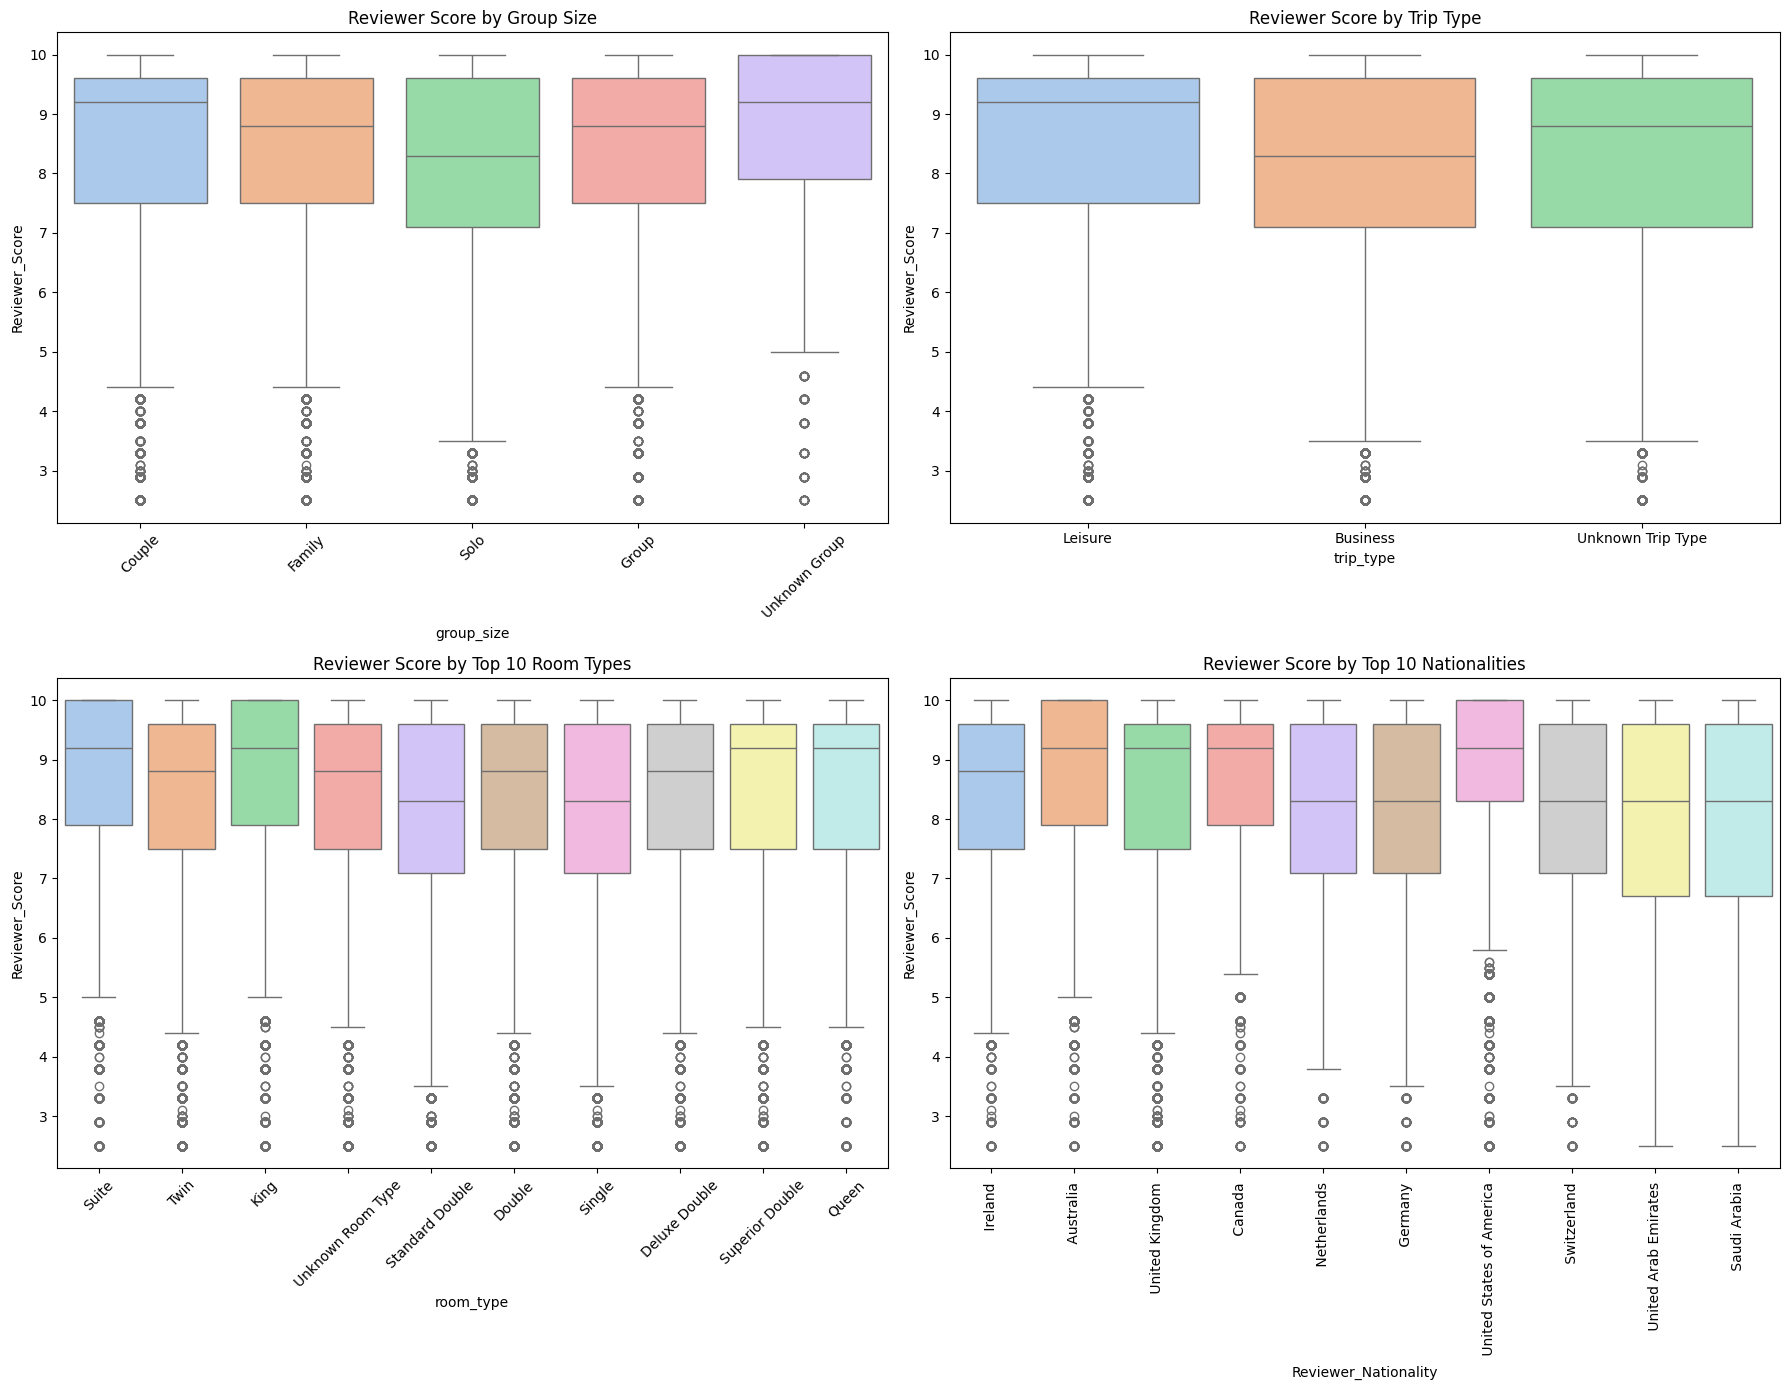

In [ ]:
# --- Reviewer_Score vs. Categorical Features (Box Plots) ---

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
axes = axes.flatten()

# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='group_size', y='Reviewer_Score', data=df, ax=axes[0], palette='pastel', hue='group_size', legend=False)
axes[0].set_title('Reviewer Score by Group Size')
axes[0].tick_params(axis='x', rotation=45)

# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='trip_type', y='Reviewer_Score', data=df, ax=axes[1], palette='pastel', hue='trip_type', legend=False)
axes[1].set_title('Reviewer Score by Trip Type')

top_room_types = df['room_type'].value_counts().head(10).index
# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='room_type', y='Reviewer_Score', data=df[df['room_type'].isin(top_room_types)], ax=axes[2], palette='pastel', hue='room_type', legend=False)
axes[2].set_title('Reviewer Score by Top 10 Room Types')
axes[2].tick_params(axis='x', rotation=45)

top_nationalities = df['Reviewer_Nationality'].value_counts().head(10).index
# Assign hue to the same column as x, and set legend=False
sns.boxplot(x='Reviewer_Nationality', y='Reviewer_Score', data=df[df['Reviewer_Nationality'].isin(top_nationalities)], ax=axes[3], palette='pastel', hue='Reviewer_Nationality', legend=False)
axes[3].set_title('Reviewer Score by Top 10 Nationalities')
axes[3].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


--- Correlation Matrix of Numerical Features ---


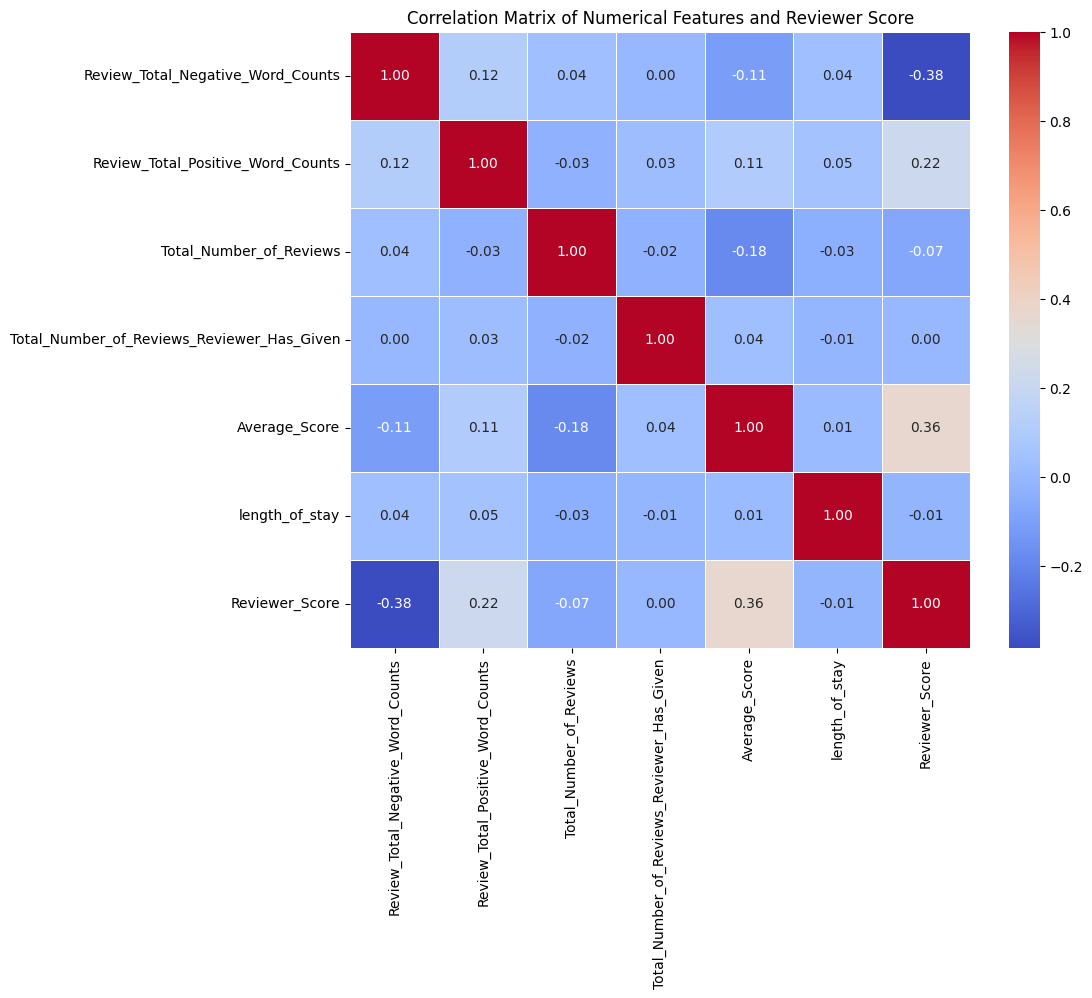

In [ ]:
# Correlation matrix for numerical features
print("\n--- Correlation Matrix of Numerical Features ---")
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols + ['Reviewer_Score']].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Reviewer Score')
plt.show()


--- Geographical Analysis ---

City and Country columns extracted.

City Distribution:
City
London       262298
Barcelona     60149
Paris         59413
Amsterdam     57211
Vienna        38937
Milan         37204
Name: count, dtype: int64

Country Distribution:
Country
United Kingdom    262298
Spain              60149
France             59413
Netherlands        57211
Austria            38937
Italy              37204
Name: count, dtype: int64


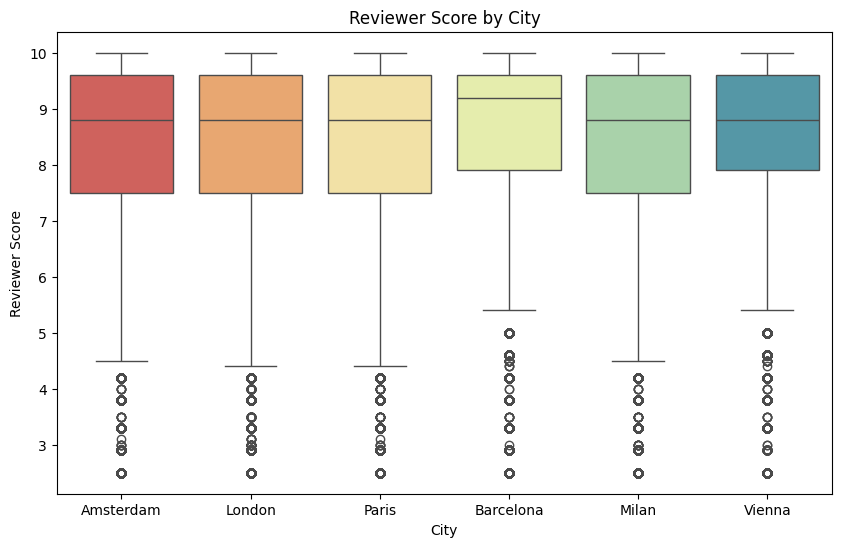

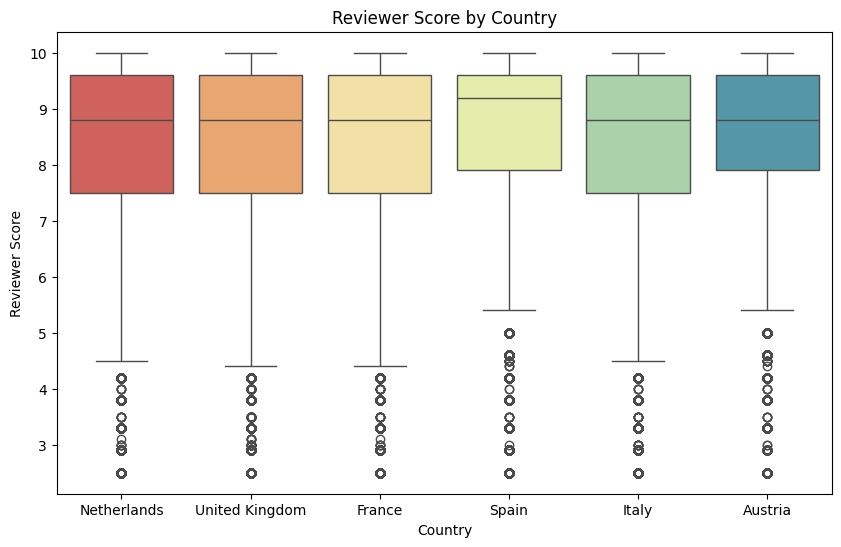


Top 10 Hotels by Average Reviewer Score:
                               Hotel_Name  Reviewer_Score
1202                           Ritz Paris        9.725000
598                     Hotel Casa Camper        9.718937
3                                      41        9.711650
472   H tel de La Tamise Esprit de France        9.688525
895                 Le Narcisse Blanc Spa        9.671930
481                 H10 Casa Mimosa 4 Sup        9.660345
628                   Hotel Eiffel Blomet        9.646667
771                      Hotel The Serras        9.623474
4      45 Park Lane Dorchester Collection        9.603571
1396                       The Soho Hotel        9.597452

Bottom 10 Hotels by Average Reviewer Score:
                                    Hotel_Name  Reviewer_Score
1401                         The Tophams Hotel        6.480000
600                            Hotel Cavendish        6.442065
1456                   Villa Lut ce Port Royal        6.385106
820               Ibis 

In [ ]:
# --- Geographical Analysis ---

print("\n--- Geographical Analysis ---")

def extract_city_country(address):
    # This heuristic assumes the predefined cities are in the address
    if 'London' in address: return 'London', 'United Kingdom'
    if 'Paris' in address: return 'Paris', 'France'
    if 'Milan' in address: return 'Milan', 'Italy'
    if 'Amsterdam' in address: return 'Amsterdam', 'Netherlands'
    if 'Barcelona' in address: return 'Barcelona', 'Spain'
    if 'Vienna' in address: return 'Vienna', 'Austria'
    return 'Unknown City', 'Unknown Country'

df['City'], df['Country'] = zip(*df['Hotel_Address'].apply(extract_city_country))

print("\nCity and Country columns extracted.")
print("\nCity Distribution:")
print(df['City'].value_counts())

print("\nCountry Distribution:")
print(df['Country'].value_counts())

plt.figure(figsize=(10, 6))
# ADDED hue='City' and legend=False
sns.boxplot(x='City', y='Reviewer_Score', data=df, palette='Spectral', hue='City', legend=False)
plt.title('Reviewer Score by City')
plt.xlabel('City')
plt.ylabel('Reviewer Score')
plt.show()

plt.figure(figsize=(10, 6))
# ADDED hue='Country' and legend=False
sns.boxplot(x='Country', y='Reviewer_Score', data=df, palette='Spectral', hue='Country', legend=False)
plt.title('Reviewer Score by Country')
plt.xlabel('Country')
plt.ylabel('Reviewer Score')
plt.show()

avg_score_per_hotel = df.groupby('Hotel_Name')['Reviewer_Score'].mean().reset_index()
avg_score_per_hotel = avg_score_per_hotel.sort_values(by='Reviewer_Score', ascending=False)
print("\nTop 10 Hotels by Average Reviewer Score:")
print(avg_score_per_hotel.head(10))
print("\nBottom 10 Hotels by Average Reviewer Score:")
print(avg_score_per_hotel.tail(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NLTK 'stopwords' corpus downloaded.

'Review_Text' column created by combining Positive and Negative reviews.
                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

                                     Negative_Review  \
0   I am so angry that i made this post available...   
1                                                      
2   Rooms are nice but for elderly a bit difficul...   
3   My room was dirty and I was afraid to walk ba...   
4   You When I booked with your company on line y...   

                                         Review_Text  
0   Only the park outside of the hotel was beauti...  
1   No real complaints the hotel was great great ...  
2   Location was good and staff were ok It is cut..

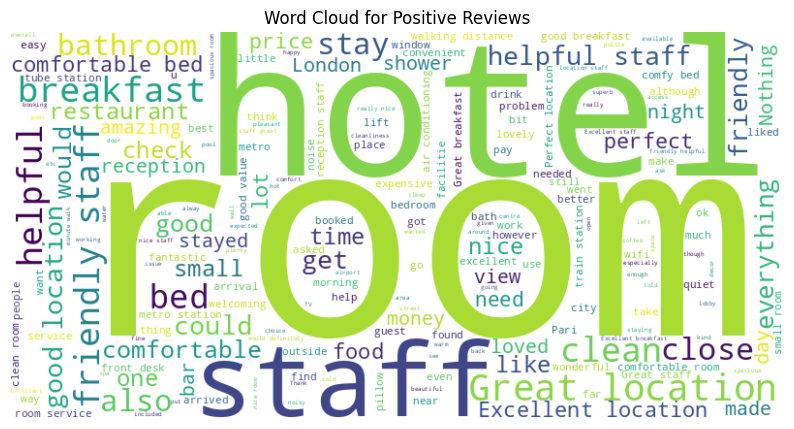


--- Word Cloud for Negative Reviews ---


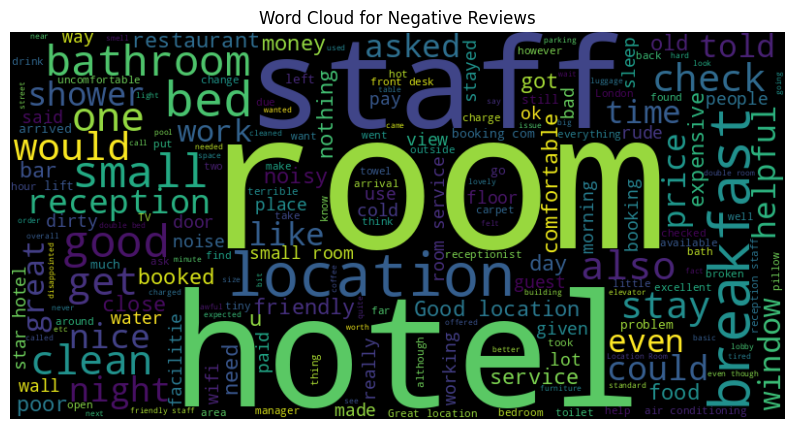


Average Review Length by Sentiment:
Sentiment
Negative    249.682911
Positive    173.041552
Name: review_length, dtype: float64


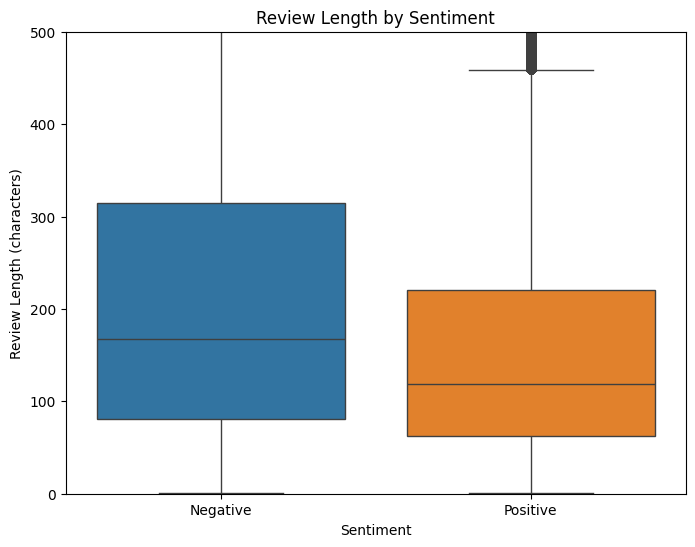

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK 'stopwords' corpus already downloaded.")
except LookupError: # Catch LookupError as raised by nltk.data.find()
    nltk.download('stopwords')
    print("NLTK 'stopwords' corpus downloaded.")

# Replace 'No Negative' and 'No Positive' with empty strings
df['Negative_Review'] = df['Negative_Review'].replace('No Negative', '')
df['Positive_Review'] = df['Positive_Review'].replace('No Positive', '')
df['Review_Text'] = df['Positive_Review'] + ' ' + df['Negative_Review']

print("\n'Review_Text' column created by combining Positive and Negative reviews.")
print(df[['Positive_Review', 'Negative_Review', 'Review_Text']].head())

# Create a 'sentiment' target variable
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')
print("\n'Sentiment' column created based on Reviewer_Score.")
print(df['Sentiment'].value_counts())

# Word Cloud for Positive Reviews
print("\n--- Word Cloud for Positive Reviews ---")
positive_reviews_text = " ".join(review for review in df[df['Sentiment'] == 'Positive']['Review_Text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white',
                               stopwords=set(nltk.corpus.stopwords.words('english'))).generate(positive_reviews_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud for Negative Reviews
print("\n--- Word Cloud for Negative Reviews ---")
negative_reviews_text = " ".join(review for review in df[df['Sentiment'] == 'Negative']['Review_Text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black',
                               stopwords=set(nltk.corpus.stopwords.words('english'))).generate(negative_reviews_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Review Length Analysis
df['review_length'] = df['Review_Text'].apply(len)
print("\nAverage Review Length by Sentiment:")
print(df.groupby('Sentiment')['review_length'].mean())

plt.figure(figsize=(8, 6))
# ADDED hue='Sentiment' and legend=False for consistency
sns.boxplot(x='Sentiment', y='review_length', data=df, hue='Sentiment', legend=False)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (characters)')
plt.ylim(0, 500)
plt.show()

#--- Deep dive further in the word analysis ---

In [ ]:
try:
    nltk.data.find('corpora/stopwords')
    print("NLTK 'stopwords' corpus already downloaded.")
except LookupError:
    nltk.download('stopwords')
    print("NLTK 'stopwords' corpus downloaded.")

NLTK 'stopwords' corpus already downloaded.


In [ ]:
# Remove the drop_duplicates line as duplicates were handled earlier
# df.drop_duplicates(inplace=True)

df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)

# Create 'Sentiment' target variable (from your previous steps)
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')

In [ ]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

print("\nApplying text preprocessing to 'Review_Text'...")
df['Review_Text_Clean'] = df['Review_Text'].apply(preprocess_text)
print("Text preprocessing complete.")




Applying text preprocessing to 'Review_Text'...
Text preprocessing complete.


In [ ]:
# --- TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams ---
print("\nStarting TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams...")
# Changed ngram_range to (1, 3) to include trigrams
tfidf_vectorizer_trigrams = TfidfVectorizer(max_features=15000, ngram_range=(1, 3)) # Increased max_features slightly due to more n-grams

# Fit and transform the cleaned review text
X_tfidf_trigrams = tfidf_vectorizer_trigrams.fit_transform(df['Review_Text_Clean'])

print(f"\nShape of TF-IDF matrix (with trigrams): {X_tfidf_trigrams.shape}")
print(f"Number of features (unique words/n-grams): {len(tfidf_vectorizer_trigrams.get_feature_names_out())}")
print("\nTF-IDF vectorization with trigrams complete.")



Starting TF-IDF Vectorization with Unigrams, Bigrams, and Trigrams...

Shape of TF-IDF matrix (with trigrams): (515212, 15000)
Number of features (unique words/n-grams): 15000

TF-IDF vectorization with trigrams complete.


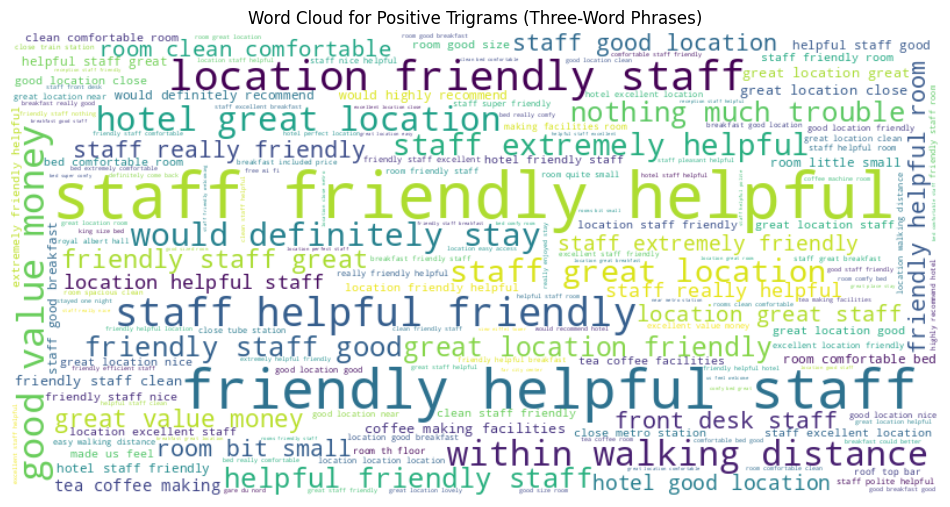

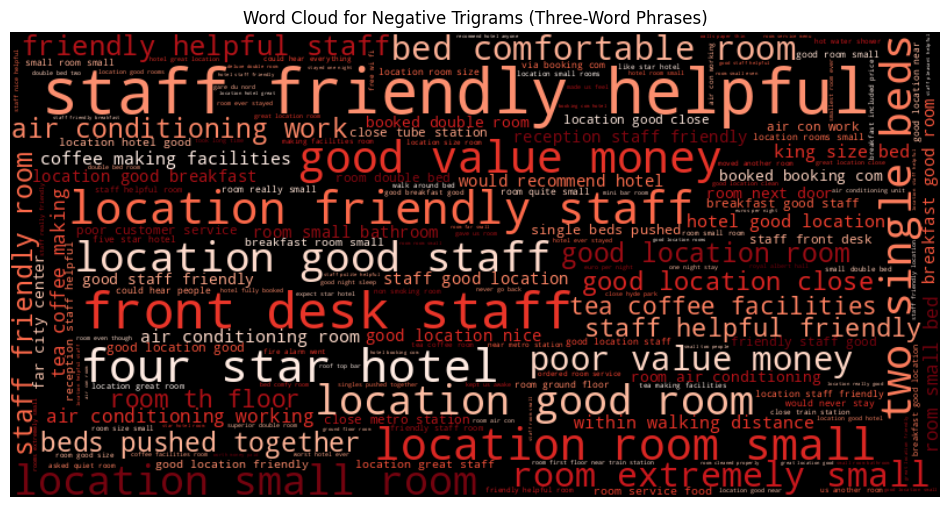


Word clouds for trigrams generated (if data was available).
Observe the difference in common phrases between positive and negative reviews.


In [ ]:
# Filter reviews by sentiment
positive_reviews_list = df[df['Sentiment'] == 'Positive']['Review_Text_Clean'].tolist()
negative_reviews_list = df[df['Sentiment'] == 'Negative']['Review_Text_Clean'].tolist()

# Handle cases where one of the lists might be empty after filtering (e.g., if a sentiment has no reviews)
if not positive_reviews_list:
    print("Warning: No positive reviews found after cleaning and filtering. Cannot generate positive trigram word cloud.")
    positive_trigram_dict = {} # Set to empty dict to avoid errors later
else:
    # Initialize CountVectorizer for trigrams only
    ngram_vectorizer_pos = CountVectorizer(ngram_range=(3, 3), max_features=2000)
    X_positive_trigrams = ngram_vectorizer_pos.fit_transform(positive_reviews_list)
    positive_trigram_counts = X_positive_trigrams.sum(axis=0)
    positive_trigram_freq = [(word, positive_trigram_counts[0, idx]) for word, idx in ngram_vectorizer_pos.vocabulary_.items()]
    positive_trigram_freq = sorted(positive_trigram_freq, key=lambda x: x[1], reverse=True)
    positive_trigram_dict = dict(positive_trigram_freq)


if not negative_reviews_list:
    print("Warning: No negative reviews found after cleaning and filtering. Cannot generate negative trigram word cloud.")
    negative_trigram_dict = {} # Set to empty dict
else:
    # Initialize CountVectorizer for trigrams only (use a new instance for negative reviews)
    ngram_vectorizer_neg = CountVectorizer(ngram_range=(3, 3), max_features=2000)
    X_negative_trigrams = ngram_vectorizer_neg.fit_transform(negative_reviews_list)
    negative_trigram_counts = X_negative_trigrams.sum(axis=0)
    negative_trigram_freq = [(word, negative_trigram_counts[0, idx]) for word, idx in ngram_vectorizer_neg.vocabulary_.items()]
    negative_trigram_freq = sorted(negative_trigram_freq, key=lambda x: x[1], reverse=True)
    negative_trigram_dict = dict(negative_trigram_freq)


# Generate Word Cloud for Positive Trigrams (only if dictionary is not empty)
if positive_trigram_dict:
    wordcloud_positive_trigrams = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_trigram_dict)
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud_positive_trigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Positive Trigrams (Three-Word Phrases)')
    plt.show()
else:
    print("No positive trigram word cloud generated due to empty data.")


# Generate Word Cloud for Negative Trigrams (only if dictionary is not empty)
if negative_trigram_dict:
    wordcloud_negative_trigrams = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(negative_trigram_dict)
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud_negative_trigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Negative Trigrams (Three-Word Phrases)')
    plt.show()
else:
    print("No negative trigram word cloud generated due to empty data.")


print("\nWord clouds for trigrams generated (if data was available).")
print("Observe the difference in common phrases between positive and negative reviews.")

In [ ]:
# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


# --- BERT training (Logistic regression) --- #

In [ ]:
file_path = 'Hotel_Reviews.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("DataFrame loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please ensure you unzipped the file correctly and it's in the current directory.")
except Exception as e:
    print(f"An error occurred while loading the DataFrame: {e}")

df.drop_duplicates(inplace=True)
df['Positive_Review_Clean'] = df['Positive_Review'].astype(str).replace('No Positive', '')
df['Negative_Review_Clean'] = df['Negative_Review'].astype(str).replace('No Negative', '')
df['Review_Text'] = df['Positive_Review_Clean'] + ' ' + df['Negative_Review_Clean']
df['Review_Text'] = df['Review_Text'].str.strip().str.replace(r'\s+', ' ', regex=True)
df.drop(columns=['Positive_Review_Clean', 'Negative_Review_Clean'], inplace=True)
df['Sentiment'] = df['Reviewer_Score'].apply(lambda score: 'Positive' if score >= 7 else 'Negative')

print(f"Total reviews after initial cleaning: {df.shape[0]}")


# --- USE THE FULL 500K+ DATASET FOR EMBEDDING GENERATION ---

df_full_data_for_bert = df.copy() # <<<--- Use a copy of the full DataFrame

# --- Check for GPU availability ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


# --- Load pre-trained BERT model and tokenizer ---
print("\nLoading BERT tokenizer and model...")
from transformers import AutoTokenizer, AutoModel # Added AutoModel import
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()
print("BERT tokenizer and model loaded.")


# --- Function to generate BERT embeddings in batches ---
def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings"):
        batch_texts = texts[i:min(i+batch_size, len(texts))]

        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

print(f"\nStarting BERT embedding generation on the FULL dataset of {df_full_data_for_bert.shape[0]} reviews.")

# Generate embeddings from the 'Review_Text' column of the FULL dataset
bert_embeddings_full_data = get_bert_embeddings(
    df_full_data_for_bert['Review_Text'].tolist(), # <<<--- Using df_full_data_for_bert
    tokenizer,
    model,
    device,
    batch_size=64,
    max_length=128
)

print(f"\nShape of generated BERT embeddings (full data): {bert_embeddings_full_data.shape}")
print("BERT embedding generation complete for full dataset.")


# --- ASSIGN X_BERT_FULL AND Y_BERT_FULL FOR TRAINING ---
X_bert_full = bert_embeddings_full_data
y_bert_full = df_full_data_for_bert['Sentiment'] # <<<--- Using sentiment from df_full_data_for_bert

print(f"\nShape of features (X_bert_full): {X_bert_full.shape}")
print(f"Shape of target (y_bert_full): {y_bert_full.shape}")


# --- SAVE THE BERT EMBEDDINGS AND PROCESSED FULL DATAFRAME ---
processed_df_path_full_data = 'hotel_reviews_processed_full_data.parquet'
bert_embeddings_path_full_data = 'bert_embeddings_full_data.npy'

print(f"\nSaving processed DataFrame (full data) to {processed_df_path_full_data}...")
df_full_data_for_bert.to_parquet(processed_df_path_full_data, index=False) # Saving the full data df
print("Processed DataFrame saved successfully!")

print(f"Saving BERT embeddings (full data) to {bert_embeddings_path_full_data}...")
np.save(bert_embeddings_path_full_data, X_bert_full) # Save the assigned X_bert_full
print("BERT embeddings saved successfully!")

print("\nRemember to download these files from the Colab 'Files' tab if you want to store them locally.")


DataFrame loaded successfully!
Total reviews after initial cleaning: 515212
Original 'df' deleted from RAM as full data copy is created for BERT embeddings.

Using device: cpu

Loading BERT tokenizer and model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT tokenizer and model loaded.

Starting BERT embedding generation on the FULL dataset of 515212 reviews.


Generating BERT Embeddings:   0%|          | 0/8051 [00:00<?, ?it/s]

#--- Balancing the class weight positive/negative --- & DistilBERT fine tunning ---

In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
import gc
import warnings
import os
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from nltk.corpus import stopwords, wordnet
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from datasets import Dataset
from tqdm.notebook import tqdm
from google.colab import files
import json

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='huggingface_hub')

# --- Configuration ---
PROCESSED_DF_PATH = 'hotel_reviews_processed_full_data.parquet'
MODEL_CHECKPOINT = "distilbert-base-uncased"
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./results_balanced_distilbert"
MODEL_SAVE_PATH = "./balanced_distilbert_hotel_reviews"

# --- NLTK Downloads and Functions for Augmentation (needed for the training split) ---
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('wordnet')
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def synonym_replacement(text, n_replacements=2):
    new_words = str(text).split()
    random_word_list = list(set([word for word in new_words if word.lower() not in stop_words]))
    if not random_word_list: return text
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = [lemma.name().replace("_", " ") for syn in wordnet.synsets(random_word) for lemma in syn.lemmas() if lemma.name().lower() != random_word.lower() and lemma.name().lower() not in stop_words]
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            try:
                idx_to_replace = new_words.index(random_word)
                new_words[idx_to_replace] = synonym
                num_replaced += 1
            except ValueError: pass
        if num_replaced >= n_replacements: break
    return " ".join(new_words)

# --- 1. Load the Original Processed Dataset ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
print(f"Loading original dataset from '{PROCESSED_DF_PATH}'...")
try:
    df = pd.read_parquet(PROCESSED_DF_PATH)
    print(f"DataFrame loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{PROCESSED_DF_PATH}' was not found.")
    exit()

# --- 2. Create Labels and Split into Unmodified Train/Test Sets ---
print("\nCreating labels and splitting data into original train/test sets...")
df['labels'] = df['Reviewer_Score'].apply(lambda score: 1 if score >= 7 else 0)
train_df_original, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['labels'])
print(f"Original training set size: {len(train_df_original)}")
print(f"Original test set size (unmodified): {len(test_df)}")

# --- 3. Augment the TRAINING DATA ONLY ---
print("\nAugmenting the training data...")
minority_df_train = train_df_original[train_df_original['labels'] == 0].copy()
majority_count_train = len(train_df_original[train_df_original['labels'] == 1])
minority_count_train = len(minority_df_train)
num_to_augment = majority_count_train - minority_count_train

if num_to_augment > 0:
    reviews_to_augment = minority_df_train['Review_Text'].tolist()
    augmented_reviews = []
    for _ in tqdm(range(num_to_augment), desc="Augmenting reviews"):
        augmented_reviews.append(synonym_replacement(random.choice(reviews_to_augment)))

    augmented_df = pd.DataFrame({'Review_Text': augmented_reviews, 'labels': [0] * len(augmented_reviews)})
    train_df_augmented = pd.concat([train_df_original, augmented_df], ignore_index=True)
    print(f"Training data augmented. New training set size: {len(train_df_augmented)}")
else:
    train_df_augmented = train_df_original.copy()
    print("No augmentation needed.")

# Split augmented training data into training and validation sets
train_df, val_df = train_test_split(train_df_augmented, test_size=0.1 / 0.9, random_state=42, stratify=train_df_augmented['labels'])
print(f"Final training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

del df, train_df_original, train_df_augmented, minority_df_train
gc.collect()
torch.cuda.empty_cache()

# --- 4. Tokenization and Model Training (as before, but with corrected datasets) ---
print(f"\nLoading tokenizer '{MODEL_CHECKPOINT}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(
        [str(text) if pd.notna(text) else "" for text in examples["Review_Text"]],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

print("\nTokenizing datasets...")
tokenized_train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
tokenized_val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
tokenized_test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

del train_df, val_df, test_df
gc.collect()
torch.cuda.empty_cache()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Using device: cuda
Loading original dataset from 'hotel_reviews_processed_full_data.parquet'...
DataFrame loaded successfully! Shape: (515212, 19)

Creating labels and splitting data into original train/test sets...
Original training set size: 463690
Original test set size (unmodified): 51522

Augmenting the training data...


Augmenting reviews:   0%|          | 0/307600 [00:00<?, ?it/s]

Training data augmented. New training set size: 771290
Final training set size: 685591
Validation set size: 85699

Loading tokenizer 'distilbert-base-uncased'...

Tokenizing datasets...


Map:   0%|          | 0/685591 [00:00<?, ? examples/s]

Map:   0%|          | 0/85699 [00:00<?, ? examples/s]

Map:   0%|          | 0/51522 [00:00<?, ? examples/s]

In [ ]:
# --- 5. Define Metrics ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    return {'accuracy': acc, 'f1_macro': f1, 'precision_macro': precision, 'recall_macro': recall}



In [ ]:
# --- 6. Load the Pre-trained Model ---
print(f"\nLoading '{MODEL_CHECKPOINT}' model for sequence classification...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)
model.to(device)
print("Model loaded and moved to device.")


Loading 'distilbert-base-uncased' model for sequence classification...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


In [ ]:
# --- 7. Define Training Arguments ---
print("\nSetting up TrainingArguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
)
print("TrainingArguments configured.")


Setting up TrainingArguments...
TrainingArguments configured.


In [ ]:
# --- 8. Initialize and Run the Trainer ---
print("\nInitializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
print("Starting model fine-tuning...")
trainer.train()
print("Fine-tuning complete.")


Initializing Trainer...
Starting model fine-tuning...


/tmp/ipython-input-3067846936.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Fine-tuning complete.



--- Evaluating on the unseen Test Set ---


Test Set Evaluation Results: {'eval_loss': 0.31265535950660706, 'eval_accuracy': 0.8966072745623229, 'eval_f1_macro': 0.8082974999810766, 'eval_precision_macro': 0.8210623128683772, 'eval_recall_macro': 0.7971633567925528, 'eval_runtime': 41.2056, 'eval_samples_per_second': 1250.365, 'eval_steps_per_second': 39.097, 'epoch': 3.0}

--- Full Classification Report on Test Set (Fine-tuned DistilBERT) ---
              precision    recall  f1-score   support

    Negative       0.71      0.65      0.68      8672
    Positive       0.93      0.95      0.94     42850

    accuracy                           0.90     51522
   macro avg       0.82      0.80      0.81     51522
weighted avg       0.89      0.90      0.89     51522



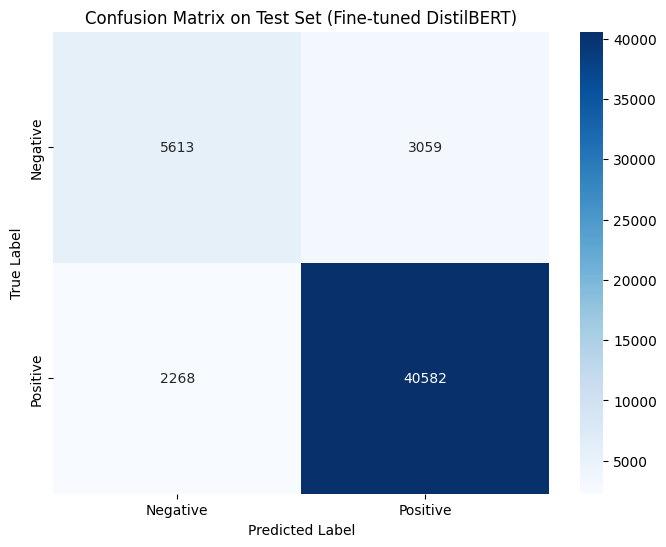

In [ ]:
# --- 9. Evaluate on the Unseen Test Set ---
print("\n--- Evaluating on the unseen Test Set ---")
test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Set Evaluation Results: {test_results}")

predictions_output = trainer.predict(tokenized_test_dataset)
y_pred_logits = predictions_output.predictions
y_pred_labels = np.argmax(y_pred_logits, axis=-1)
y_true_labels = predictions_output.label_ids

print("\n--- Full Classification Report on Test Set (Fine-tuned DistilBERT) ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set (Fine-tuned DistilBERT)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import os
import json
import pandas as pd
from sklearn.metrics import classification_report

# --- ADD THIS LINE ---
RESULTS_DIR = "./evaluation_results_balanced_distilbert"
# --- END ADDITION ---

print(f"\nSaving fine-tuned model and tokenizer to: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print("Fine-tuned model and tokenizer saved successfully!")

os.makedirs(RESULTS_DIR, exist_ok=True)
final_metrics_json = {
    "test_results": test_results,
    "classification_report": classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Positive'], output_dict=True, zero_division=0),
    "model_name": MODEL_CHECKPOINT,
    "epochs": NUM_TRAIN_EPOCHS,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "max_length": MAX_LENGTH,
    "timestamp": pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
}
json_filename = os.path.join(RESULTS_DIR, f"balanced_distilbert_metrics_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(json_filename, 'w') as f:
    json.dump(final_metrics_json, f, indent=4)
print(f"\nNumerical metrics (JSON) saved to: {json_filename}")


Saving fine-tuned model and tokenizer to: ./balanced_distilbert_hotel_reviews
Fine-tuned model and tokenizer saved successfully!

Numerical metrics (JSON) saved to: ./evaluation_results_balanced_distilbert/balanced_distilbert_metrics_20250811_185330.json


In [ ]:
# --- 11. Inference on New Unseen Data (using the fine-tuned model) ---
print("\n--- Starting inference on new data using the fine-tuned model ---")

# Assuming the following variables are already in memory from previous cells:
# MODEL_SAVE_PATH, NEW_DATA_URL, MAX_LENGTH, device

print(f"Loading fine-tuned model and tokenizer from '{MODEL_SAVE_PATH}'...")
try:
    fine_tuned_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
    fine_tuned_model.to(device)
    fine_tuned_model.eval()
    print("Fine-tuned model loaded successfully for inference.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

print(f"\nLoading new data from URL: {NEW_DATA_URL}")
try:
    new_df = pd.read_csv(NEW_DATA_URL)
    new_df['Review_Text'] = new_df['Review_Text'].astype(str)
    print(f"New data loaded successfully! Found {new_df.shape[0]} reviews.")
except Exception as e:
    print(f"Error loading new data: {e}")
    exit()

INFERENCE_BATCH_SIZE = 64
print("\nMaking predictions on the new data in batches...")
predictions = []
review_texts = new_df['Review_Text'].tolist()

for i in tqdm(range(0, len(review_texts), INFERENCE_BATCH_SIZE), desc="Predicting in batches"):
    batch_texts = review_texts[i:i + INFERENCE_BATCH_SIZE]

    tokenized_batch = fine_tuned_tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = fine_tuned_model(**tokenized_batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.extend(batch_predictions)

    del tokenized_batch, outputs, logits, batch_predictions
    gc.collect()
    torch.cuda.empty_cache()

new_df['Predicted_Sentiment'] = predictions
new_df['Predicted_Sentiment'] = new_df['Predicted_Sentiment'].map({1: 'Positive', 0: 'Negative'})
print("Predictions made and added to the DataFrame.")

print("\n--- Final Predictions on New Data ---")
print(new_df[['Review_Text', 'Predicted_Sentiment']].head(10))
print("\nPrediction distribution:")
print(new_df['Predicted_Sentiment'].value_counts())

output_file_path = 'hotel_sentiment_predictions_balanced_distilbert.csv'
print(f"\nSaving results to {output_file_path}...")
new_df.to_csv(output_file_path, index=False)
print("Results saved successfully.")

try:
    files.download(output_file_path)
    print("\nDownload initiated. Check your browser for the file.")
except Exception as e:
    print(f"Error during file download: {e}")
    print("You can manually download the file from the Colab file browser (folder icon on the left).")


--- Starting inference on new data using the fine-tuned model ---
Loading fine-tuned model and tokenizer from './balanced_distilbert_hotel_reviews'...
Fine-tuned model loaded successfully for inference.

Loading new data from URL: https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv
New data loaded successfully! Found 60000 reviews.

Making predictions on the new data in batches...


Predicting in batches:   0%|          | 0/938 [00:00<?, ?it/s]

Predictions made and added to the DataFrame.

--- Final Predictions on New Data ---
                                         Review_Text Predicted_Sentiment
0  Everything is good. Hotel check in line was so...            Negative
1          Luxury hotel 🏨 Rooms: All kind of foods 💫            Positive
2  Terrible customer service on the phone, call f...            Negative
3                     Rooms: Very good accommodation            Positive
4  the beds were confortable, the service was ver...            Positive
5  Jacob, SweetbAyesha and Vishal were supper swe...            Negative
6  The room was so great. We had sauna in the roo...            Positive
7  A lot of options for eating, drinking, shoppin...            Positive
8  The hotel staff was terrible specially the rec...            Negative
9                                         Excellent!            Positive

Prediction distribution:
Predicted_Sentiment
Negative    31851
Positive    28149
Name: count, dtype: int64

Savi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated. Check your browser for the file.


# **# Fine Tunning with RoBERTa #**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Using device: cuda
Loading original dataset from 'hotel_reviews_processed_full_data.parquet'...
DataFrame loaded successfully! Shape: (515212, 19)

Creating labels and splitting data into original train/test sets...
Original training set size: 463690
Original test set size (unmodified): 51522

Augmenting the training data...


Augmenting reviews:   0%|          | 0/307600 [00:00<?, ?it/s]

Training data augmented. New training set size: 771290
Final training set size: 685591
Validation set size: 85699

Loading tokenizer 'roberta-base'...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Tokenizing datasets...


Map:   0%|          | 0/685591 [00:00<?, ? examples/s]

Map:   0%|          | 0/85699 [00:00<?, ? examples/s]

Map:   0%|          | 0/51522 [00:00<?, ? examples/s]


Loading 'roberta-base' model for sequence classification...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-302265984.py:175: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model loaded and moved to device.

Setting up TrainingArguments...
TrainingArguments configured.

Initializing Trainer...
Starting model fine-tuning...


Fine-tuning complete.

--- Evaluating on the unseen Test Set ---


Test Set Evaluation Results: {'eval_loss': 0.2891453802585602, 'eval_accuracy': 0.9020806645704748, 'eval_f1_macro': 0.8173914318119062, 'eval_precision_macro': 0.8327882109966686, 'eval_recall_macro': 0.8042249388581983, 'eval_runtime': 78.0651, 'eval_samples_per_second': 659.987, 'eval_steps_per_second': 20.637, 'epoch': 3.0}

--- Full Classification Report on Test Set (Fine-tuned RoBERTa) ---
              precision    recall  f1-score   support

    Negative       0.73      0.66      0.69      8672
    Positive       0.93      0.95      0.94     42850

    accuracy                           0.90     51522
   macro avg       0.83      0.80      0.82     51522
weighted avg       0.90      0.90      0.90     51522



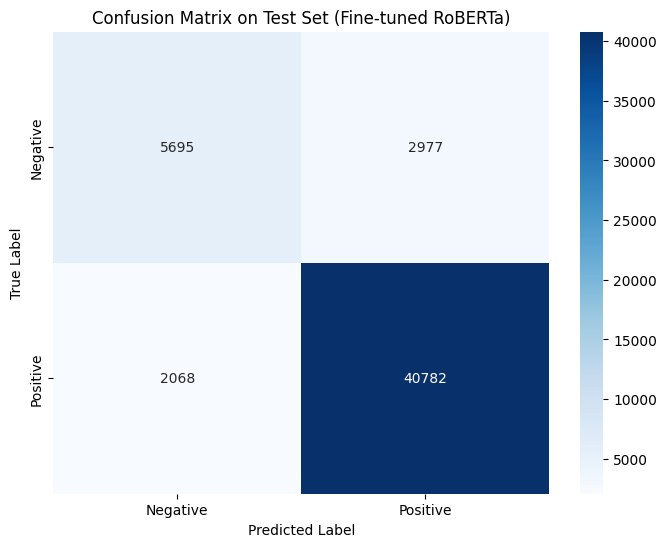


Saving fine-tuned model and tokenizer to: ./roberta_hotel_reviews
Fine-tuned model and tokenizer saved successfully!

Numerical metrics (JSON) saved to: ./evaluation_results_roberta/roberta_metrics_20250811_230505.json

--- Starting inference on new data using the fine-tuned model ---


In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
import gc
import warnings
import os
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from nltk.corpus import stopwords, wordnet
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import json

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from tqdm.notebook import tqdm
from google.colab import files
from sklearn.linear_model import LogisticRegression

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='huggingface_hub')

# --- Configuration for RoBERTa Fine-Tuning ---
PROCESSED_DF_PATH = 'hotel_reviews_processed_full_data.parquet'
MODEL_CHECKPOINT = "roberta-base" # The new model to fine-tune
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 2e-5
OUTPUT_DIR = "./results_roberta"
MODEL_SAVE_PATH = "./roberta_hotel_reviews"
RESULTS_DIR = "./evaluation_results_roberta"

# --- NLTK Downloads and Functions for Augmentation (needed for the training split) ---
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('wordnet')
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def synonym_replacement(text, n_replacements=2):
    new_words = str(text).split()
    random_word_list = list(set([word for word in new_words if word.lower() not in stop_words]))
    if not random_word_list: return text
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = [lemma.name().replace("_", " ") for syn in wordnet.synsets(random_word) for lemma in syn.lemmas() if lemma.name().lower() != random_word.lower() and lemma.name().lower() not in stop_words]
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            try:
                idx_to_replace = new_words.index(random_word)
                new_words[idx_to_replace] = synonym
                num_replaced += 1
            except ValueError: pass
        if num_replaced >= n_replacements: break
    return " ".join(new_words)

# --- 1. Load the Original Processed Dataset ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
print(f"Loading original dataset from '{PROCESSED_DF_PATH}'...")
try:
    df = pd.read_parquet(PROCESSED_DF_PATH)
    print(f"DataFrame loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{PROCESSED_DF_PATH}' was not found.")
    exit()

# --- 2. Create Labels and Split into Unmodified Train/Test Sets ---
print("\nCreating labels and splitting data into original train/test sets...")
df['labels'] = df['Reviewer_Score'].apply(lambda score: 1 if score >= 7 else 0)
train_df_original, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['labels'])
print(f"Original training set size: {len(train_df_original)}")
print(f"Original test set size (unmodified): {len(test_df)}")

# --- 3. Augment the TRAINING DATA ONLY ---
print("\nAugmenting the training data...")
minority_df_train = train_df_original[train_df_original['labels'] == 0].copy()
majority_count_train = len(train_df_original[train_df_original['labels'] == 1])
minority_count_train = len(minority_df_train)
num_to_augment = majority_count_train - minority_count_train

if num_to_augment > 0:
    reviews_to_augment = minority_df_train['Review_Text'].tolist()
    augmented_reviews = []
    for _ in tqdm(range(num_to_augment), desc="Augmenting reviews"):
        augmented_reviews.append(synonym_replacement(random.choice(reviews_to_augment)))

    augmented_df = pd.DataFrame({'Review_Text': augmented_reviews, 'labels': [0] * len(augmented_reviews)})
    train_df_augmented = pd.concat([train_df_original, augmented_df], ignore_index=True)
    print(f"Training data augmented. New training set size: {len(train_df_augmented)}")
else:
    train_df_augmented = train_df_original.copy()
    print("No augmentation needed.")

train_df, val_df = train_test_split(train_df_augmented, test_size=0.1 / 0.9, random_state=42, stratify=train_df_augmented['labels'])
print(f"Final training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

del df, train_df_original, train_df_augmented, minority_df_train
gc.collect()
torch.cuda.empty_cache()

# --- 4. Tokenization ---
print(f"\nLoading tokenizer '{MODEL_CHECKPOINT}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(
        [str(text) if pd.notna(text) else "" for text in examples["Review_Text"]],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

print("\nTokenizing datasets...")
tokenized_train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
tokenized_val_dataset = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
tokenized_test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

del train_df, val_df, test_df
gc.collect()
torch.cuda.empty_cache()

# --- 5. Define Metrics ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    return {'accuracy': acc, 'f1_macro': f1, 'precision_macro': precision, 'recall_macro': recall}

# --- 6. Load the Pre-trained Model ---
print(f"\nLoading '{MODEL_CHECKPOINT}' model for sequence classification...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)
model.to(device)
print("Model loaded and moved to device.")

# --- 7. Define Training Arguments ---
print("\nSetting up TrainingArguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=torch.cuda.is_available(),
)
print("TrainingArguments configured.")

# --- 8. Initialize and Run the Trainer ---
print("\nInitializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
print("Starting model fine-tuning...")
trainer.train()
print("Fine-tuning complete.")

# --- 9. Evaluate on the Unseen Test Set ---
print("\n--- Evaluating on the unseen Test Set ---")
test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Set Evaluation Results: {test_results}")

predictions_output = trainer.predict(tokenized_test_dataset)
y_pred_logits = predictions_output.predictions
y_pred_labels = np.argmax(y_pred_logits, axis=-1)
y_true_labels = predictions_output.label_ids

print("\n--- Full Classification Report on Test Set (Fine-tuned RoBERTa) ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Positive']))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set (Fine-tuned RoBERTa)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 10. Save the Fine-tuned Model and Evaluation Metrics ---
print(f"\nSaving fine-tuned model and tokenizer to: {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print("Fine-tuned model and tokenizer saved successfully!")

os.makedirs(RESULTS_DIR, exist_ok=True)
final_metrics_json = {
    "test_results": test_results,
    "classification_report": classification_report(y_true_labels, y_pred_labels, target_names=['Negative', 'Positive'], output_dict=True, zero_division=0),
    "model_name": MODEL_CHECKPOINT,
    "epochs": NUM_TRAIN_EPOCHS,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "max_length": MAX_LENGTH,
    "timestamp": pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
}
json_filename = os.path.join(RESULTS_DIR, f"roberta_metrics_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(json_filename, 'w') as f:
    json.dump(final_metrics_json, f, indent=4)
print(f"\nNumerical metrics (JSON) saved to: {json_filename}")

# --- 11. Inference on New Unseen Data (using the fine-tuned model) ---
print("\n--- Starting inference on new data using the fine-tuned model ---")
# This is a separate block for later, as the fine-tuning process takes time.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore", category=UserWarning, module='huggingface_hub')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

models_to_download = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "roberta-base"
]

for model_name in tqdm(models_to_download, desc="Downloading models"):
    print(f"\n--- Downloading and loading tokenizer and model for {model_name} ---")
    try:
        # Download and cache the tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("Tokenizer downloaded.")

        # Download and cache the model
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        print("Model downloaded.")

        print(f"✅ Download for {model_name} complete.")

    except Exception as e:
        print(f"❌ Error downloading {model_name}: {e}")

print("\nAll models have been downloaded and cached successfully.")

Using device: cuda




--- Downloading and loading tokenizer and model for bert-base-uncased ---
Tokenizer downloaded.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model downloaded.
✅ Download for bert-base-uncased complete.

--- Downloading and loading tokenizer and model for distilbert-base-uncased ---
Tokenizer downloaded.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model downloaded.
✅ Download for distilbert-base-uncased complete.

--- Downloading and loading tokenizer and model for roberta-base ---
Tokenizer downloaded.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model downloaded.
✅ Download for roberta-base complete.

All models have been downloaded and cached successfully.


#--- Compare the Performance of ALL Models ---

This is the TEST dataset we have

https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv

In [ ]:
import pandas as pd
import numpy as np
import torch
import joblib
import gc
import warnings
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from datasets import Dataset
from tqdm.notebook import tqdm
from google.colab import files # For downloading the CSV

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='huggingface_hub')

# --- Configuration ---
PROCESSED_DF_PATH = 'hotel_reviews_processed_full_data.parquet' # Original data for test set
NEW_DATA_URL = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv"

BERT_LOGREG_FULL_MODEL_PATH = "logistic_regression_model_bert_embeddings_full_data.joblib"
BERT_LOGREG_BALANCED_MODEL_PATH = "logistic_regression_model_bert_embeddings_balanced_data.joblib"
DISTILBERT_MODEL_DIR = "./balanced_distilbert_hotel_reviews"
ROBERTA_MODEL_DIR = "./roberta_hotel_reviews"

BERT_BASE_MODEL_NAME = "bert-base-uncased"
DISTILBERT_BASE_MODEL_NAME = "distilbert-base-uncased"
ROBERTA_BASE_MODEL_NAME = "roberta-base"

MAX_LENGTH = 128
INFERENCE_BATCH_SIZE = 8 # Keep this small for transformer inference to avoid OOM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# --- Helper Functions (defined once) ---

def get_bert_embeddings(texts, tokenizer_name, model_name, device, batch_size=INFERENCE_BATCH_SIZE, max_length=MAX_LENGTH):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    all_embeddings = []
    string_texts = [str(t) for t in texts]
    for i in tqdm(range(0, len(string_texts), batch_size), desc="Generating BERT Embeddings"):
        batch_texts = string_texts[i:min(i + batch_size, len(string_texts))]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
        sentence_embeddings = model_output.pooler_output
        all_embeddings.append(sentence_embeddings.cpu().numpy())
    del tokenizer, model
    gc.collect()
    torch.cuda.empty_cache()
    return np.vstack(all_embeddings)

def predict_with_transformer(model_path, texts, base_tokenizer_name, device, batch_size=INFERENCE_BATCH_SIZE, max_length=MAX_LENGTH, return_probabilities=False):
    tokenizer = AutoTokenizer.from_pretrained(base_tokenizer_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    model.eval()

    all_predictions = []
    all_probabilities = [] if return_probabilities else None

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Predicting with {os.path.basename(model_path)}"):
        batch_texts = texts[i:min(i + batch_size, len(texts))]
        tokenized_batch = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**tokenized_batch)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
            all_predictions.extend(batch_preds)
            if return_probabilities:
                batch_probs = torch.softmax(logits, dim=-1).cpu().numpy()[:, 1] # Prob of positive class
                all_probabilities.extend(batch_probs)
        del tokenized_batch, outputs, logits
        gc.collect()
        torch.cuda.empty_cache()

    del tokenizer, model
    gc.collect()
    torch.cuda.empty_cache()

    if return_probabilities:
        return all_predictions, all_probabilities
    else:
        return all_predictions

def get_metrics_for_model(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], output_dict=True, zero_division=0)
    return {
        "Modelo": model_name,
        "Accuracy": accuracy,
        "F1-Macro": report['macro avg']['f1-score'],
        "Precision-Macro": report['macro avg']['precision'],
        "Recall-Macro": report['macro avg']['recall'],
        "Positive Precision": report['Positive']['precision'],
        "Positive Recall": report['Positive']['recall'],
        "Positive F1": report['Positive']['f1-score'],
        "Negative Precision": report['Negative']['precision'],
        "Negative Recall": report['Negative']['recall'],
        "Negative F1": report['Negative']['f1-score']
    }

# ==============================================================================
## Part 1: Theoretical Evaluation on `test_df` (with metrics)
# ==============================================================================

print("\n" + "="*80)
print("== Part 1: Theoretical Evaluation on Original Test Set (with metrics) ==")
print("="*80)

# --- Load the Original, Untouched Test Set ---
print(f"Loading original processed data from '{PROCESSED_DF_PATH}' to get the test set...")
try:
    df_original = pd.read_parquet(PROCESSED_DF_PATH)
    df_original['labels'] = df_original['Reviewer_Score'].apply(lambda score: 1 if score >= 7 else 0)

    _, test_df_original = train_test_split(df_original, test_size=0.1, random_state=42, stratify=df_original['labels'])

    print(f"Original test set loaded. Size: {len(test_df_original)}")
    y_true_test_original = test_df_original['labels'].tolist() # True labels for evaluation

    del df_original
    gc.collect()
    torch.cuda.empty_cache()

except FileNotFoundError:
    print(f"Error: The file '{PROCESSED_DF_PATH}' was not found. Cannot perform theoretical evaluation.")
    test_df_original = pd.DataFrame({'Review_Text': [], 'labels': []}) # Create empty df to avoid errors
    y_true_test_original = []
except Exception as e:
    print(f"An error occurred during test set loading for theoretical evaluation: {e}")
    test_df_original = pd.DataFrame({'Review_Text': [], 'labels': []})
    y_true_test_original = []


# --- List to store results for each model's theoretical performance ---
all_theoretical_metrics = []

# --- Evaluate Each Model on the Original Test Set ---

# BERT (Logistic Regression) on Imbalanced Data
print("\n--- Evaluating BERT (Logistic Regression) on Imbalanced Data ---")
if not test_df_original.empty:
    try:
        log_reg_full_model = joblib.load(BERT_LOGREG_FULL_MODEL_PATH)
        test_embeddings_bert_full = get_bert_embeddings(test_df_original['Review_Text'].tolist(), BERT_BASE_MODEL_NAME, BERT_BASE_MODEL_NAME, device)
        y_pred_bert_full_str = log_reg_full_model.predict(test_embeddings_bert_full)
        y_pred_bert_full = np.array([1 if p == 'Positive' else 0 for p in y_pred_bert_full_str])
        all_theoretical_metrics.append(get_metrics_for_model("BERT (LogReg) - Imbalanced Data", y_true_test_original, y_pred_bert_full))
        del log_reg_full_model, test_embeddings_bert_full, y_pred_bert_full_str, y_pred_bert_full
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: BERT LogReg (Imbalanced) model not found at {BERT_LOGREG_FULL_MODEL_PATH}. Skipping theoretical evaluation.")
    except Exception as e:
        print(f"Error evaluating BERT LogReg (Imbalanced) model: {e}. Skipping theoretical evaluation.")

# BERT (Logistic Regression) on Balanced Data
print("\n--- Evaluating BERT (Logistic Regression) on Balanced Data ---")
if not test_df_original.empty:
    try:
        log_reg_balanced_model = joblib.load(BERT_LOGREG_BALANCED_MODEL_PATH)
        test_embeddings_bert_balanced = get_bert_embeddings(test_df_original['Review_Text'].tolist(), BERT_BASE_MODEL_NAME, BERT_BASE_MODEL_NAME, device)
        y_pred_bert_balanced_str = log_reg_balanced_model.predict(test_embeddings_bert_balanced)
        y_pred_bert_balanced = np.array([1 if p == 'Positive' else 0 for p in y_pred_bert_balanced_str])
        all_theoretical_metrics.append(get_metrics_for_model("BERT (LogReg) - Balanced Data", y_true_test_original, y_pred_bert_balanced))
        del log_reg_balanced_model, test_embeddings_bert_balanced, y_pred_bert_balanced_str, y_pred_bert_balanced
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: BERT LogReg (Balanced) model not found at {BERT_LOGREG_BALANCED_MODEL_PATH}. Skipping theoretical evaluation.")
    except Exception as e:
        print(f"Error evaluating BERT LogReg (Balanced) model: {e}. Skipping theoretical evaluation.")

# Fine-tuned DistilBERT
print("\n--- Evaluating Fine-tuned DistilBERT ---")
if not test_df_original.empty:
    try:
        y_pred_distilbert = predict_with_transformer(DISTILBERT_MODEL_DIR, test_df_original['Review_Text'].tolist(), DISTILBERT_BASE_MODEL_NAME, device)
        all_theoretical_metrics.append(get_metrics_for_model("DistilBERT (Fine-tuned)", y_true_test_original, y_pred_distilbert))
        del y_pred_distilbert
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: DistilBERT model not found at {DISTILBERT_MODEL_DIR}. Skipping theoretical evaluation.")
    except Exception as e:
        print(f"Error evaluating DistilBERT model: {e}. Skipping theoretical evaluation.")

# Fine-tuned RoBERTa
print("\n--- Evaluating Fine-tuned RoBERTa ---")
if not test_df_original.empty:
    try:
        y_pred_roberta = predict_with_transformer(ROBERTA_MODEL_DIR, test_df_original['Review_Text'].tolist(), ROBERTA_BASE_MODEL_NAME, device)
        all_theoretical_metrics.append(get_metrics_for_model("RoBERTa (Fine-tuned)", y_true_test_original, y_pred_roberta))
        del y_pred_roberta
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: RoBERTa model not found at {ROBERTA_MODEL_DIR}. Skipping theoretical evaluation.")
    except Exception as e:
        print(f"Error evaluating RoBERTa model: {e}. Skipping theoretical evaluation.")

# --- Display Theoretical Comparison Table ---
print("\n--- Theoretical Model Performance Comparison Table ---")
if all_theoretical_metrics:
    theoretical_comparison_df = pd.DataFrame(all_theoretical_metrics)
    ordered_cols = [
        "Modelo", "Accuracy", "F1-Macro", "Precision-Macro", "Recall-Macro",
        "Positive Precision", "Positive Recall", "Positive F1",
        "Negative Precision", "Negative Recall", "Negative F1"
    ]
    theoretical_comparison_df = theoretical_comparison_df[ordered_cols]
    for col in theoretical_comparison_df.columns:
        if col not in ["Modelo"]:
            theoretical_comparison_df[col] = theoretical_comparison_df[col].apply(lambda x: f"{x:.4f}")
    print(theoretical_comparison_df.to_string(index=False))
    theoretical_comparison_csv_path = "theoretical_model_performance_comparison.csv"
    theoretical_comparison_df.to_csv(theoretical_comparison_csv_path, index=False)
    print(f"\nTheoretical comparison table saved to {theoretical_comparison_csv_path}")
    try:
        files.download(theoretical_comparison_csv_path)
    except Exception as e:
        print(f"Error downloading theoretical comparison CSV: {e}")
else:
    print("No models were successfully evaluated for theoretical comparison.")

# ==============================================================================
## Part 2: Real-Life Prediction Comparison on `new_df` (without metrics)
# ==============================================================================

print("\n\n" + "="*80)
print("== Part 2: Real-Life Prediction Comparison on New Unseen Data ==")
print("="*80)

# --- Load the New Data for Prediction ---
print(f"Loading new data for prediction from URL: {NEW_DATA_URL}...")
try:
    new_df_real_life = pd.read_csv(NEW_DATA_URL)
    new_df_real_life['Review_Text'] = new_df_real_life['Review_Text'].astype(str).str.strip()
    print(f"New data loaded successfully! Size: {len(new_df_real_life)} reviews.")
    print("\nWARNING: This dataset does NOT contain ground truth labels. No performance metrics (Accuracy, F1, etc.) can be calculated.")

except Exception as e:
    print(f"An error occurred during new data loading for real-life comparison: {e}")
    new_df_real_life = pd.DataFrame({'Review_Text': []})

# --- Make Predictions with each Model on the New Data ---

# BERT (Logistic Regression) on Balanced Data
print("\n--- Making predictions with BERT (Logistic Regression) on Balanced Data ---")
if not new_df_real_life.empty:
    try:
        log_reg_balanced_model = joblib.load(BERT_LOGREG_BALANCED_MODEL_PATH)
        test_embeddings_bert_balanced = get_bert_embeddings(new_df_real_life['Review_Text'].tolist(), BERT_BASE_MODEL_NAME, BERT_BASE_MODEL_NAME, device)

        y_pred_bert_balanced_str = log_reg_balanced_model.predict(test_embeddings_bert_balanced)
        y_prob_bert_balanced = log_reg_balanced_model.predict_proba(test_embeddings_bert_balanced)[:, 1] # Get probabilities

        new_df_real_life['BERT_Predicted_Sentiment'] = y_pred_bert_balanced_str
        new_df_real_life['BERT_Prob_Positive'] = y_prob_bert_balanced

        del log_reg_balanced_model, test_embeddings_bert_balanced, y_pred_bert_balanced_str, y_prob_bert_balanced
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: BERT LogReg (Balanced) model not found at {BERT_LOGREG_BALANCED_MODEL_PATH}. Skipping real-life predictions.")
    except Exception as e:
        print(f"Error making real-life predictions with BERT LogReg (Balanced) model: {e}. Skipping predictions.")

# Fine-tuned DistilBERT
print("\n--- Making predictions with fine-tuned DistilBERT ---")
if not new_df_real_life.empty:
    try:
        y_pred_distilbert_int, y_prob_distilbert = predict_with_transformer(DISTILBERT_MODEL_DIR, new_df_real_life['Review_Text'].tolist(), DISTILBERT_BASE_MODEL_NAME, device, return_probabilities=True)

        new_df_real_life['DistilBERT_Predicted_Sentiment'] = np.array([ 'Positive' if p == 1 else 'Negative' for p in y_pred_distilbert_int])
        new_df_real_life['DistilBERT_Prob_Positive'] = y_prob_distilbert

        del y_pred_distilbert_int, y_prob_distilbert
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: DistilBERT model not found at {DISTILBERT_MODEL_DIR}. Skipping real-life predictions.")
    except Exception as e:
        print(f"Error making real-life predictions with DistilBERT model: {e}. Skipping predictions.")

# Fine-tuned RoBERTa
print("\n--- Making predictions with fine-tuned RoBERTa ---")
if not new_df_real_life.empty:
    try:
        y_pred_roberta_int, y_prob_roberta = predict_with_transformer(ROBERTA_MODEL_DIR, new_df_real_life['Review_Text'].tolist(), ROBERTA_BASE_MODEL_NAME, device, return_probabilities=True)

        new_df_real_life['RoBERTa_Predicted_Sentiment'] = np.array([ 'Positive' if p == 1 else 'Negative' for p in y_pred_roberta_int])
        new_df_real_life['RoBERTa_Prob_Positive'] = y_prob_roberta

        del y_pred_roberta_int, y_prob_roberta
        gc.collect()
        torch.cuda.empty_cache()
    except FileNotFoundError:
        print(f"Warning: RoBERTa model not found at {ROBERTA_MODEL_DIR}. Skipping real-life predictions.")
    except Exception as e:
        print(f"Error making real-life predictions with RoBERTa model: {e}. Skipping predictions.")


# --- Display Real-Life Prediction Comparison Table ---
print("\n--- Real-Life Model Prediction Comparison ---")

sentiment_cols_real_life = [col for col in new_df_real_life.columns if 'Predicted_Sentiment' in col]
if 'Review_Text' in new_df_real_life.columns and sentiment_cols_real_life:
    print("\nPredicted Sentiments (First 20 Reviews):")
    print(new_df_real_life[['Review_Text'] + sentiment_cols_real_life].head(20).to_string(index=False))
else:
    print("No sentiment predictions available for real-life data.")

prob_cols_real_life = [col for col in new_df_real_life.columns if 'Prob_Positive' in col]
if 'Review_Text' in new_df_real_life.columns and prob_cols_real_life:
    print("\nPredicted Probabilities of Positive Sentiment (First 20 Reviews):")
    print(new_df_real_life[['Review_Text'] + prob_cols_real_life].head(20).to_string(index=False))
else:
    print("No probability predictions available for real-life data.")

# Hard Voting
available_sentiment_cols_real_life = [col for col in ['BERT_Predicted_Sentiment', 'DistilBERT_Predicted_Sentiment', 'RoBERTa_Predicted_Sentiment'] if col in new_df_real_life.columns]
if len(available_sentiment_cols_real_life) >= 2:
    temp_df_for_hard_vote = new_df_real_life[available_sentiment_cols_real_life].replace({'Positive': 1, 'Negative': 0})
    hard_voting_predictions_numeric = temp_df_for_hard_vote.mode(axis=1)[0]
    new_df_real_life['Hard_Voting_Prediction'] = hard_voting_predictions_numeric.map({1: 'Positive', 0: 'Negative'})
    print("\nHard Voting Predictions (First 20 Reviews):")
    print(new_df_real_life[['Review_Text', 'Hard_Voting_Prediction']].head(20).to_string(index=False))
else:
    print("\nSkipping Hard Voting: Not enough model predictions available for real-life data.")

# Soft Voting
available_prob_cols_real_life = [col for col in ['BERT_Prob_Positive', 'DistilBERT_Prob_Positive', 'RoBERTa_Prob_Positive'] if col in new_df_real_life.columns]
if len(available_prob_cols_real_life) >= 2:
    new_df_real_life['Soft_Voting_Avg_Prob_Positive'] = new_df_real_life[available_prob_cols_real_life].mean(axis=1)
    new_df_real_life['Soft_Voting_Prediction'] = new_df_real_life['Soft_Voting_Avg_Prob_Positive'].apply(lambda x: 'Positive' if x > 0.5 else 'Negative')
    print("\nSoft Voting Predictions (First 20 Reviews):")
    print(new_df_real_life[['Review_Text', 'Soft_Voting_Prediction']].head(20).to_string(index=False))
else:
    print("\nSkipping Soft Voting: Not enough model probabilities available for real-life data.")


print("\nPrediction counts for each model and voting method (Real-Life Data):")
all_prediction_cols_real_life = sentiment_cols_real_life + ['Hard_Voting_Prediction', 'Soft_Voting_Prediction']
for col in all_prediction_cols_real_life:
    if col in new_df_real_life.columns:
        print(f"\n{col}:\n", new_df_real_life[col].value_counts())

output_file_path_real_life = 'real_life_predictions_comparison.csv'
print(f"\nSaving real-life prediction comparison to '{output_file_path_real_life}'...")
new_df_real_life.to_csv(output_file_path_real_life, index=False)
print("File saved successfully.")

try:
    files.download(output_file_path_real_life)
except Exception as e:
    print(f"Error downloading real-life comparison CSV: {e}")
    print("You can manually download the file from the Colab file browser.")

print("\n" + "="*80)
print("== Combined Evaluation Complete ==")
print("="*80)



Using device: cuda

== Part 1: Theoretical Evaluation on Original Test Set (with metrics) ==
Loading original processed data from 'hotel_reviews_processed_full_data.parquet' to get the test set...
Original test set loaded. Size: 51522

--- Evaluating BERT (Logistic Regression) on Imbalanced Data ---


Generating BERT Embeddings:   0%|          | 0/6441 [00:00<?, ?it/s]


--- Evaluating BERT (Logistic Regression) on Balanced Data ---


Generating BERT Embeddings:   0%|          | 0/6441 [00:00<?, ?it/s]


--- Evaluating Fine-tuned DistilBERT ---


Predicting with balanced_distilbert_hotel_reviews:   0%|          | 0/6441 [00:00<?, ?it/s]


--- Evaluating Fine-tuned RoBERTa ---


Predicting with roberta_hotel_reviews:   0%|          | 0/6441 [00:00<?, ?it/s]


--- Theoretical Model Performance Comparison Table ---
                         Modelo Accuracy F1-Macro Precision-Macro Recall-Macro Positive Precision Positive Recall Positive F1 Negative Precision Negative Recall Negative F1
BERT (LogReg) - Imbalanced Data   0.8703   0.7251          0.7879       0.6933             0.8922          0.9601      0.9249             0.6837          0.4265      0.5254
  BERT (LogReg) - Balanced Data   0.8685   0.7247          0.7811       0.6948             0.8929          0.9567      0.9237             0.6693          0.4328      0.5257
        DistilBERT (Fine-tuned)   0.8966   0.8083          0.8211       0.7972             0.9299          0.9471      0.9384             0.7123          0.6473      0.6782
           RoBERTa (Fine-tuned)   0.9020   0.8173          0.8327       0.8042             0.9319          0.9517      0.9417             0.7335          0.6566      0.6929

Theoretical comparison table saved to theoretical_model_performance_comparison

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



== Part 2: Real-Life Prediction Comparison on New Unseen Data ==
Loading new data for prediction from URL: https://docs.google.com/spreadsheets/d/e/2PACX-1vSQOXCs_XKH1DCvzmo0RdGmm4tfT_sKRCsCKBIpkMqdRq2xKHG_61Rtz7_S7cA_O5mmlng1sd5jgoeR/pub?output=csv...
New data loaded successfully! Size: 60000 reviews.


--- Making predictions with BERT (Logistic Regression) on Balanced Data ---


Generating BERT Embeddings:   0%|          | 0/7500 [00:00<?, ?it/s]


--- Making predictions with fine-tuned DistilBERT ---


Predicting with balanced_distilbert_hotel_reviews:   0%|          | 0/7500 [00:00<?, ?it/s]


--- Making predictions with fine-tuned RoBERTa ---


Predicting with roberta_hotel_reviews:   0%|          | 0/7500 [00:00<?, ?it/s]


--- Real-Life Model Prediction Comparison ---

Predicted Sentiments (First 20 Reviews):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

/tmp/ipython-input-3233777136.py:328: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df_for_hard_vote = new_df_real_life[available_sentiment_cols_real_life].replace({'Positive': 1, 'Negative': 0})



Hard Voting Predictions (First 20 Reviews):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


== Combined Evaluation Complete ==


#** STREAMLIT APP **#

In [ ]:
!pip install streamlit pyngrok -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import json
import os # Import os to read environment variables
import requests
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import io

# --- NLTK Downloads (required for stopwords) ---
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- 0. OpenAI API Key Configuration ---
# IMPORTANT: Read the API key from environment variables
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "") # Reads from env var, defaults to empty string if not found

# --- 1. Configuration for your fine-tuned sentiment model ---
MODEL_SAVE_PATH = "./roberta_hotel_reviews" # e.g., "./balanced_distilbert_hotel_reviews"

# Set device for PyTorch models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- NEW: Minimum reviews threshold for dashboard display ---
MIN_REVIEWS_FOR_DASHBOARD = 5

# --- 2. Load your fine-tuned sentiment model and tokenizer (cached for performance) ---
@st.cache_resource
def load_sentiment_model():
    """Load the fine-tuned sentiment model and tokenizer."""
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
        model.to(device)
        model.eval()
        st.success("Sentiment model loaded successfully!")
        return tokenizer, model
    except Exception as e:
        st.error(f"Error loading sentiment model: {e}")
        st.info("Please ensure the model directory exists and contains all necessary files.")
        return None, None

sentiment_tokenizer, sentiment_model = load_sentiment_model()

# --- 3. Define Sentiment Prediction Function (for a single review) ---
def predict_sentiment_single(review_text):
    """Predicts sentiment for a single text using the loaded sentiment model."""
    if not sentiment_model or not sentiment_tokenizer:
        return None, None

    encoded_input = sentiment_tokenizer(
        review_text,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = sentiment_model(**encoded_input)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(probabilities, dim=1).item()

    sentiment_map = {1: "Positive", 0: "Negative"}
    predicted_sentiment = sentiment_map.get(predicted_class_id, "Unknown")
    positive_probability = probabilities[0, 1].item()

    return predicted_sentiment, positive_probability

# --- 4. OpenAI Integration for Summarization and Thematic Insights (for a single review) ---
def get_openai_insights_single(review_text):
    """
    Calls OpenAI API to get summary, key points categorized by theme, and action items for a single review.
    Uses a structured JSON response format.
    """
    if not OPENAI_API_KEY:
        st.warning("OpenAI API key not set. Cannot generate advanced insights.")
        return None

    prompt = f"""
    Analyze the following hotel review. Identify key positive and negative aspects, categorizing them into themes like 'Staff', 'Room', 'Location', 'Food', 'Amenities', 'Cleanliness', 'Value', 'Service', 'Facilities', 'Noise', 'Check-in/Check-out', 'Booking', 'Internet/Wi-Fi', 'Parking', 'Breakfast'.
    For each theme, list specific points.
    Then, provide actionable recommendations for the hotel based on the review.

    Format the output as a JSON object with the following keys:
    {{
        "summary": "...",
        "positive_aspects": [
            {{"theme": "...", "points": ["...", "..."]}},
            ...
        ],
        "negative_aspects": [
            {{"theme": "...", "points": ["...", "..."]}},
            ...
        ],
        "action_items": ["...", "...", "..."]
    }}

    Review: "{review_text}"
    """

    response_schema = {
        "type": "OBJECT",
        "properties": {
            "summary": {"type": "STRING"},
            "positive_aspects": {
                "type": "ARRAY",
                "items": {
                    "type": "OBJECT",
                    "properties": {
                        "theme": {"type": "STRING"},
                        "points": {"type": "ARRAY", "items": {"type": "STRING"}}
                    },
                    "propertyOrdering": ["theme", "points"]
                }
            },
            "negative_aspects": {
                "type": "ARRAY",
                "items": {
                    "type": "OBJECT",
                    "properties": {
                        "theme": {"type": "STRING"},
                        "points": {"type": "ARRAY", "items": {"type": "STRING"}}
                    },
                    "propertyOrdering": ["theme", "points"]
                }
            },
            "action_items": {
                "type": "ARRAY",
                "items": {"type": "STRING"}
            }
        },
        "propertyOrdering": ["summary", "positive_aspects", "negative_aspects", "action_items"]
    }

    api_url = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-preview-05-20:generateContent"
    headers = {
        'Content-Type': 'application/json',
        'x-goog-api-key': OPENAI_API_KEY
    }
    payload = {
        "contents": [{"role": "user", "parts": [{"text": prompt}]}],
        "generationConfig": {
            "responseMimeType": "application/json",
            "responseSchema": response_schema
        }
    }

    retries = 3
    for attempt in range(retries):
        try:
            response = requests.post(api_url, headers=headers, json=payload, timeout=30)
            response.raise_for_status()

            result = response.json()
            if result.get('candidates') and result['candidates'][0].get('content') and result['candidates'][0]['content'].get('parts'):
                json_string = result['candidates'][0]['content']['parts'][0]['text']
                parsed_json = json.loads(json_string)
                return parsed_json
            else:
                st.error("Unexpected AI response structure.")
                return None
        except requests.exceptions.RequestException as req_err:
            st.warning(f"Attempt {attempt + 1} failed (Request Error): {req_err}")
        except json.JSONDecodeError as json_err:
            st.warning(f"Attempt {attempt + 1} failed (JSON Decode Error): {json_err}. Response: {response.text}")
        except Exception as e:
            st.warning(f"Attempt {attempt + 1} failed (General Error): {e}")

        if attempt < retries - 1:
            time.sleep(2 ** attempt)
        else:
            st.error("Failed to get insights from AI after multiple retries.")
            return None
    return None

# --- 5. Main Streamlit UI ---
st.set_page_config(layout="wide", page_title="Hotel Review Dashboard")
st.title("Hotel Review Insights Dashboard 🏨📊")
st.markdown("""
_Upload a CSV file containing hotel reviews to get sentiment analysis, AI-generated summaries,
thematic insights, and actionable recommendations._
""")

uploaded_file = st.file_uploader("Upload your CSV file (must have a 'Review_Text' column)", type="csv")

if uploaded_file is not None:
    try:
        reviews_df = pd.read_csv(uploaded_file)

        if 'Review_Text' not in reviews_df.columns:
            st.error("CSV must contain a 'Review_Text' column.")
            st.stop()
        reviews_df['Review_Text'] = reviews_df['Review_Text'].astype(str).str.strip()
        reviews_df = reviews_df[reviews_df['Review_Text'] != ''].reset_index(drop=True)

        if reviews_df.empty:
            st.warning("No valid reviews found in the uploaded file after cleaning.")
            st.stop()

        st.success(f"Successfully loaded {len(reviews_df)} reviews.")
        st.dataframe(reviews_df.head())

        st.markdown("---")
        st.subheader("Processing Reviews...")

        all_sentiments = []
        all_positive_probs = []
        all_summaries = []
        all_positive_aspects = []
        all_negative_aspects = []
        all_action_items = []

        ai_insight_limit = st.slider("Number of reviews for AI insights (OpenAI calls can be slow/costly):",
                                     min_value=0, max_value=min(50, len(reviews_df)), value=min(5, len(reviews_df)))

        progress_text = "Analyzing reviews. Please wait..."
        my_bar = st.progress(0, text=progress_text)

        for i, row in reviews_df.iterrows():
            review_text = row['Review_Text']

            sentiment, prob_pos = predict_sentiment_single(review_text)
            all_sentiments.append(sentiment)
            all_positive_probs.append(prob_pos)

            if i < ai_insight_limit:
                insights = get_openai_insights_single(review_text)
                if insights:
                    all_summaries.append(insights.get('summary'))
                    all_positive_aspects.append(insights.get('positive_aspects', []))
                    all_negative_aspects.append(insights.get('negative_aspects', []))
                    all_action_items.append(insights.get('action_items', []))
                else:
                    all_summaries.append(None)
                    all_positive_aspects.append([])
                    all_negative_aspects.append([])
                    all_action_items.append([])
            else:
                all_summaries.append(None)
                all_positive_aspects.append([])
                all_negative_aspects.append([])
                all_action_items.append([])

            my_bar.progress((i + 1) / len(reviews_df), text=progress_text)

        reviews_df['Predicted_Sentiment'] = all_sentiments
        reviews_df['Positive_Probability'] = all_positive_probs
        reviews_df['AI_Summary'] = all_summaries
        reviews_df['AI_Positive_Aspects'] = all_positive_aspects
        reviews_df['AI_Negative_Aspects'] = all_negative_aspects
        reviews_df['AI_Action_Items'] = all_action_items

        st.success("Review processing complete!")

        # --- Conditional Display of Dashboard Elements ---
        if len(reviews_df) < MIN_REVIEWS_FOR_DASHBOARD:
            st.warning(f"Upload at least {MIN_REVIEWS_FOR_DASHBOARD} reviews to see the full dashboard insights.")
            st.dataframe(reviews_df[['Review_Text', 'Predicted_Sentiment', 'Positive_Probability']].head())
        else:
            # --- Overall Property Score (0-10) ---
            st.markdown("---")
            st.subheader("Overall Property Sentiment Score")
            numeric_sentiments = reviews_df['Predicted_Sentiment'].map({'Positive': 1, 'Negative': 0})
            overall_avg_sentiment = numeric_sentiments.mean() if not numeric_sentiments.empty else 0
            property_score = round(overall_avg_sentiment * 10, 1) # Scale to 0-10

            st.metric(label="Property Sentiment Score (0-10)", value=f"{property_score}/10")
            if property_score >= 7.5:
                st.success("Great job! Keep up the excellent work. 👍")
            elif property_score >= 5.0:
                st.info("Good performance, but there's room for improvement. 📈")
            else:
                st.error("Attention needed! Significant improvements are recommended. 🚨")

            # --- Dashboard Layout ---
            st.markdown("---")
            st.subheader("Dashboard Overview")

            col1, col2 = st.columns(2)

            with col1:
                st.markdown("#### Predicted Sentiment Distribution")
                sentiment_counts = reviews_df['Predicted_Sentiment'].value_counts()
                fig_dist, ax_dist = plt.subplots(figsize=(5, 3))
                sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax_dist, palette={'Positive': 'green', 'Negative': 'red'})
                ax_dist.set_title('Sentiment Counts')
                ax_dist.set_xlabel('Sentiment')
                ax_dist.set_ylabel('Number of Reviews')
                st.pyplot(fig_dist)

                st.markdown("#### Word Clouds")
                positive_reviews_text = " ".join(reviews_df[reviews_df['Predicted_Sentiment'] == 'Positive']['Review_Text'].tolist())
                negative_reviews_text = " ".join(reviews_df[reviews_df['Predicted_Sentiment'] == 'Negative']['Review_Text'].tolist())

                fig_wc, axes_wc = plt.subplots(2, 1, figsize=(5, 5))

                # Positive Word Cloud
                if positive_reviews_text.strip():
                    wordcloud_positive = WordCloud(width=400, height=200, background_color='white', stopwords=stop_words).generate(positive_reviews_text)
                    axes_wc[0].imshow(wordcloud_positive, interpolation='bilinear')
                    axes_wc[0].set_title('Positive Reviews')
                    axes_wc[0].axis('off')
                else:
                    axes_wc[0].text(0.5, 0.5, "No Positive Reviews", ha='center', va='center', fontsize=12, color='gray')
                    axes_wc[0].axis('off')

                # Negative Word Cloud
                if negative_reviews_text.strip():
                    wordcloud_negative = WordCloud(width=400, height=200, background_color='black', stopwords=stop_words, colormap='Reds').generate(negative_reviews_text)
                    axes_wc[1].imshow(wordcloud_negative, interpolation='bilinear')
                    axes_wc[1].set_title('Negative Reviews')
                    axes_wc[1].axis('off')
                else:
                    axes_wc[1].text(0.5, 0.5, "No Negative Reviews", ha='center', va='center', fontsize=12, color='gray')
                    axes_wc[1].axis('off')

                plt.tight_layout()
                st.pyplot(fig_wc)

            with col2:
                st.markdown("#### Aggregated Thematic Insights")
                all_pos_themes = {}
                for aspects_list in reviews_df['AI_Positive_Aspects'].dropna():
                    for aspect in aspects_list:
                        theme = aspect.get('theme', 'Other Positive')
                        all_pos_themes[theme] = all_pos_themes.get(theme, 0) + len(aspect.get('points', []))

                all_neg_themes = {}
                for aspects_list in reviews_df['AI_Negative_Aspects'].dropna():
                    for aspect in aspects_list:
                        theme = aspect.get('theme', 'Other Negative')
                        all_neg_themes[theme] = all_neg_themes.get(theme, 0) + len(aspect.get('points', []))

                if all_pos_themes or all_neg_themes:
                    theme_data = []
                    all_themes = sorted(list(set(list(all_pos_themes.keys()) + list(all_neg_themes.keys()))))
                    for theme in all_themes:
                        theme_data.append({
                            'Theme': theme,
                            'Positive Mentions': all_pos_themes.get(theme, 0),
                            'Negative Mentions': all_neg_themes.get(theme, 0)
                        })
                    theme_df = pd.DataFrame(theme_data).set_index('Theme')
                    st.dataframe(theme_df)

                    fig_themes, ax_themes = plt.subplots(figsize=(8, 4))
                    theme_df.plot(kind='bar', ax=ax_themes, color=['green', 'red'])
                    ax_themes.set_title('Mentions by Theme')
                    ax_themes.set_ylabel('Number of Mentions')
                    ax_themes.tick_params(axis='x', rotation=45)
                    plt.tight_layout()
                    st.pyplot(fig_themes)

                else:
                    st.info("No AI insights generated for thematic analysis (adjust slider or upload more reviews).")

            st.markdown("---")
            st.subheader("Individual Review Insights")
            for i, row in reviews_df.iterrows():
                with st.expander(f"Review {i+1} - Predicted: {row['Predicted_Sentiment']} (Prob: {row['Positive_Probability']:.2f})"):
                    st.write(f"**Review Text:** {row['Review_Text']}")
                    st.write(f"**Predicted Sentiment:** {row['Predicted_Sentiment']}")
                    st.write(f"**Positive Probability:** {row['Positive_Probability']:.2f}")

                    if row['AI_Summary']:
                        st.write(f"**AI Summary:** {row['AI_Summary']}")

                        st.markdown("##### AI Positive Aspects:")
                        if row['AI_Positive_Aspects']:
                            for aspect in row['AI_Positive_Aspects']:
                                st.markdown(f"**{aspect.get('theme', 'N/A')}:**")
                                for point in aspect.get('points', []):
                                    st.write(f"- {point}")
                        else:
                            st.write("No specific positive aspects identified by AI.")

                        st.markdown("##### AI Negative Aspects:")
                        if row['AI_Negative_Aspects']:
                            for aspect in row['AI_Negative_Aspects']:
                                st.markdown(f"**{aspect.get('theme', 'N/A')}:**")
                                for point in aspect.get('points', []):
                                    st.write(f"- {point}")
                        else:
                            st.write("No specific negative aspects identified by AI.")

                        st.markdown("##### AI Actionable Recommendations:")
                        if row['AI_Action_Items']:
                            for item in row['AI_Action_Items']:
                                st.write(f"- {item}")
                        else:
                            st.write("No specific action items identified by AI.")
                    else:
                        st.info("AI insights not generated for this review (limit reached or API error).")

    except Exception as e:
        st.error(f"An error occurred: {e}")
        st.info("Please check your CSV file format and try again.")

Overwriting app.py


In [ ]:
from pyngrok import ngrok
import subprocess
import time
from google.colab import userdata # Import userdata here

# Terminate any existing ngrok tunnels
ngrok.kill()

# --- Retrieve API Key from Colab Secrets and set as Environment Variable ---
try:
    colab_api_key = userdata.get('OPENAI_API_KEY')
    if colab_api_key:
        os.environ['OPENAI_API_KEY'] = colab_api_key # Set as environment variable
        print("API key successfully loaded from Colab Secrets and set as environment variable.")
    else:
        print("Warning: 'OPENAI_API_KEY' not found in Colab Secrets. AI insights will not work.")
except Exception as e:
    print(f"Error retrieving API key from Colab Secrets: {e}. AI insights will not work.")
    os.environ['OPENAI_API_KEY'] = "" # Ensure it's empty if retrieval fails

# Start Streamlit in the background
print("Starting Streamlit app in the background...")
process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(5) # Give Streamlit a moment to start

# Set your ngrok authtoken (REQUIRED!)
# Get it from https://dashboard.ngrok.com/get-started/your-authtoken
# ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN") # Uncomment and paste your authtoken here

# Open a ngrok tunnel to the Streamlit port
print("Opening ngrok tunnel...")
public_url = ngrok.connect(8501)
print(f"Your Streamlit app is live at: {public_url}")

# To keep the Colab cell running and the tunnel active, you can monitor the process
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Streamlit app stopped.")
    process.terminate()
    ngrok.kill()

API key successfully loaded from Colab Secrets and set as environment variable.
Starting Streamlit app in the background...
Opening ngrok tunnel...
Your Streamlit app is live at: NgrokTunnel: "https://b9b7823d5b43.ngrok-free.app" -> "http://localhost:8501"
Streamlit app stopped.
